In [20]:
# try to use part 2 to do same thing as quest.

from plot_ult import *
import math
def getinf(x):
    return np.nonzero( np.isinf( np.atleast_1d(x) ) )


def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx
    
'''
notations:
    phi, different intensities, as stimuli
    theta, different thresholds
    agent(theta), the psychometric function depends on threshold theta, output to a probability distribution of actions (0,1) and we randomly take one.

procedure:
    start from a gaussian prior.
    for all phi
        calculate I ~= weighted sum (var(behavior under phi and theta) for all theta). weight is the theta prior.
    use the max I phi as next stimuli.
    
'''


class QuestObject():

    def __init__(self,tGuess,tGuessSd,pThreshold,beta,delta,gamma,grain=0.01,range=None):
        super(QuestObject, self).__init__()
        grain = float(grain) # make sure grain is a float
        if range is None:
            dim = 500
        else:
            if range <= 0:
                raise ValueError('argument "range" must be greater than zero.')
            dim=range/grain
            dim=2*math.ceil(dim/2.0) # round up to even integer
        self.updatePdf = True
        self.warnPdf = True
        self.normalizePdf = False
        self.tGuess = tGuess
        self.tGuessSd = tGuessSd
        self.pThreshold = pThreshold
        self.beta = beta
        self.delta = delta
        self.gamma = gamma
        self.grain = grain
        self.dim = dim
        self.recompute()

    def mean(self):
        """Mean of Quest posterior pdf.

        Get the mean threshold estimate.

        This was converted from the Psychtoolbox's QuestMean function.
        """
        return self.tGuess + np.sum(self.pdf*self.x)/np.sum(self.pdf)

    def mode(self):
        """Mode of Quest posterior pdf.

        t,p=q.mode()
        't' is the mode threshold estimate
        'p' is the value of the (unnormalized) pdf at t.

        This was converted from the Psychtoolbox's QuestMode function.
        """
        iMode = np.argsort(self.pdf)[-1]
        p=self.pdf[iMode]
        t=self.x[iMode]+self.tGuess
        return t

    def p(self,x):
        """probability of correct response at intensity x.

        p=q.p(x)

        The probability of a correct (or yes) response at intensity x,
        assuming threshold is at x=0.

        This was converted from the Psychtoolbox's QuestP function.
        """
        if x < self.x2[0]:
            return self.x2[0]
        if x > self.x2[-1]:
            return self.x2[-1]
        return np.interp(x,self.x2,self.p2)

    def pdf_at(self,t):
        """The (unnormalized) probability density of candidate threshold 't'.

        This was converted from the Psychtoolbox's QuestPdf function.
        """
        i=int(round((t-self.tGuess)/self.grain))+1+self.dim/2
        i=min(len(self.pdf),max(1,i))-1
        p=self.pdf[int(i)]
        return p

    def quantile(self,quantileOrder=None):
        """Get Quest recommendation for next trial level.

        intensity=q.quantile([quantileOrder])

        Gets a quantile of the pdf in the struct q.  You may specify
        the desired quantileOrder, e.g. 0.5 for median, or, making two
        calls, 0.05 and 0.95 for a 90confidence interval.  If the
        'quantileOrder' argument is not supplied, then it's taken from
        the QuestObject instance. __init__() uses recompute() to
        compute the optimal quantileOrder and saves that in the
        QuestObject instance; this quantileOrder yields a quantile
        that is the most informative intensity for the next trial.

        This was converted from the Psychtoolbox's QuestQuantile function.
        """
        if quantileOrder is None:
            quantileOrder = self.quantileOrder
        p = np.cumsum(self.pdf)
        if len(getinf(p[-1])[0]):
            raise RuntimeError('pdf is not finite')
        if p[-1]==0:
            raise RuntimeError('pdf is all zero')
        m1p = np.concatenate(([-1],p))
        index = np.nonzero( m1p[1:]-m1p[:-1] )[0]
        if len(index) < 2:
            raise RuntimeError('pdf has only %g nonzero point(s)'%len(index))
        ires = np.interp([quantileOrder*p[-1]],p[index],self.x[index])[0]
        return self.tGuess+ires

    def sd(self):
        """Standard deviation of Quest posterior pdf.

        Get the sd of the threshold distribution.

        This was converted from the Psychtoolbox's QuestSd function."""
        p=np.sum(self.pdf)
        sd=math.sqrt(np.sum(self.pdf*self.x**2)/p-(np.sum(self.pdf*self.x)/p)**2)
        return sd

    def simulate(self,tTest,tActual):
        """Simulate an observer with given Quest parameters.

        response=QuestSimulate(q,intensity,tActual)

        Simulate the response of an observer with threshold tActual.

        This was converted from the Psychtoolbox's QuestSimulate function."""
        t = min( max(tTest-tActual, self.x2[0]), self.x2[-1] )
        response= np.interp([t],self.x2,self.p2)[0] > random.random()
        return response

    def simulate_p(self,tTest,tActual):
        t = min( max(tTest-tActual, self.x2[0]), self.x2[-1] ) # clip
        return np.interp([t],self.x2,self.p2)[0] # take an inteprotated value
        
    def recompute(self):
        """Recompute the psychometric function & pdf.

        Call this immediately after changing a parameter of the
        psychometric function. recompute() uses the specified
        parameters in 'self' to recompute the psychometric
        function. It then uses the newly computed psychometric
        function and the history in self.intensity and self.response
        to recompute the pdf. (recompute() does nothing if q.updatePdf
        is False.)

        This was converted from the Psychtoolbox's QuestRecompute function."""
        if not self.updatePdf:
            return
        if self.gamma > self.pThreshold:
            warnings.warn( 'reducing gamma from %.2f to 0.5'%self.gamma)
            self.gamma = 0.5
        self.i = np.arange(-self.dim/2, self.dim/2+1)
        self.x = self.i * self.grain
        self.pdf = np.exp(-0.5*(self.x/self.tGuessSd)**2)
        self.pdf = self.pdf/np.sum(self.pdf)
        i2 = np.arange(-self.dim,self.dim+1)
        self.x2 = i2*self.grain
        self.p2 = self.delta*self.gamma+(1-self.delta)*(1-(1-self.gamma)*np.exp(-10**(self.beta*self.x2)))
        if self.p2[0] >= self.pThreshold or self.p2[-1] <= self.pThreshold:
            raise RuntimeError('psychometric function range [%.2f %.2f] omits %.2f threshold'%(self.p2[0],self.p2[-1],self.pThreshold)) # XXX
        if len(getinf(self.p2)[0]):
            raise RuntimeError('psychometric function p2 is not finite')
        index = np.nonzero( self.p2[1:]-self.p2[:-1] )[0] # strictly monotonic subset
        if len(index) < 2:
            raise RuntimeError('psychometric function has only %g strictly monotonic points'%len(index))
        self.xThreshold = np.interp([self.pThreshold],self.p2[index],self.x2[index])[0]
        self.p2 = self.delta*self.gamma+(1-self.delta)*(1-(1-self.gamma)*np.exp(-10**(self.beta*(self.x2+self.xThreshold))))
        if len(getinf(self.p2)[0]):
            raise RuntimeError('psychometric function p2 is not finite')
        self.s2 = np.array( ((1-self.p2)[::-1], self.p2[::-1]) ) # wrong, right
        if not hasattr(self,'intensity') or not hasattr(self,'response'):
            self.intensity = []
            self.response = []
        if len(getinf(self.s2)[0]):
            raise RuntimeError('psychometric function s2 is not finite')

        eps = 1e-14

        pL = self.p2[0]
        pH = self.p2[-1]
        pE = pH*math.log(pH+eps)-pL*math.log(pL+eps)+(1-pH+eps)*math.log(1-pH+eps)-(1-pL+eps)*math.log(1-pL+eps)
        pE = 1/(1+math.exp(pE/(pL-pH)))
        self.quantileOrder=(pE-pL)/(pH-pL)

        if len(getinf(self.pdf)[0]):
            raise RuntimeError('prior pdf is not finite')

        # recompute the pdf from the historical record of trials
        for intensity, response in zip(self.intensity, self.response):
            inten = max(-1e10,min(1e10, intensity)) # make intensity finite
            ii = len(self.pdf) + self.i-round((inten-self.tGuess)/self.grain)-1
            if ii[0]<0:
                ii = ii-ii[0]
            if ii[-1]>=self.s2.shape[1]:
                ii = ii+self.s2.shape[1]-ii[-1]-1
            iii = ii.astype(np.int_)
            if not np.allclose(ii,iii):
                raise ValueError('truncation error')
            self.pdf = self.pdf*self.s2[response,iii]
            if self.normalizePdf and ii % 100 == 0:
                self.pdf = self.pdf/np.sum(self.pdf) # avoid underflow; keep the pdf normalized
        if self.normalizePdf:
            self.pdf = self.pdf/np.sum(self.pdf) # avoid underflow; keep the pdf normalized
        if len(getinf(self.pdf)[0]):
            raise RuntimeError('prior pdf is not finite')

    def update(self,intensity,response):
        """Update Quest posterior pdf.

        Update self to reflect the results of this trial. The
        historical records self.intensity and self.response are always
        updated, but self.pdf is only updated if self.updatePdf is
        true. You can always call QuestRecompute to recreate q.pdf
        from scratch from the historical record.

        This was converted from the Psychtoolbox's QuestUpdate function."""

        if response < 0 or response > self.s2.shape[0]:
            raise RuntimeError('response %g out of range 0 to %d'%(response,self.s2.shape[0]))
        if self.updatePdf:
            inten = max(-1e10,min(1e10,intensity)) # make intensity finite
            ii = len(self.pdf) + self.i-round((inten-self.tGuess)/self.grain)-1
            if ii[0]<0 or ii[-1] > self.s2.shape[1]:
                if self.warnPdf:
                    low=(1-len(self.pdf)-self.i[0])*self.grain+self.tGuess
                    high=(self.s2.shape[1]-len(self.pdf)-self.i[-1])*self.grain+self.tGuess
                    warnings.warn( 'intensity %.2f out of range %.2f to %.2f. Pdf will be inexact.'%(intensity,low,high),
                                   RuntimeWarning,stacklevel=2)
                if ii[0]<0:
                    ii = ii-ii[0]
                else:
                    ii = ii+self.s2.shape[1]-ii[-1]-1
            iii = ii.astype(np.int_)
            if not np.allclose(ii,iii):
                raise ValueError('truncation error')
            self.pdf = self.pdf*self.s2[response,iii]
            # plt.plot(self.x,self.s2[response,iii],label='update function')
            if self.normalizePdf:
                self.pdf=self.pdf/np.sum(self.pdf)
        # keep a historical record of the trials
        self.intensity.append(intensity)
        self.response.append(response)

    def pdf_theta(self, theta):
        self.i = np.arange(-self.dim/2, self.dim/2+1)
        self.x = self.i * self.grain
        self.pdf = np.exp(-0.5*(self.x/self.tGuessSd)**2)
        self.pdf = self.pdf/np.sum(self.pdf)


Trial   1 at  0.1 is wrong
Trial   2 at  1.2 is right
Trial   3 at  1.0 is right
Trial   4 at  0.9 is wrong
Trial   5 at  1.4 is right


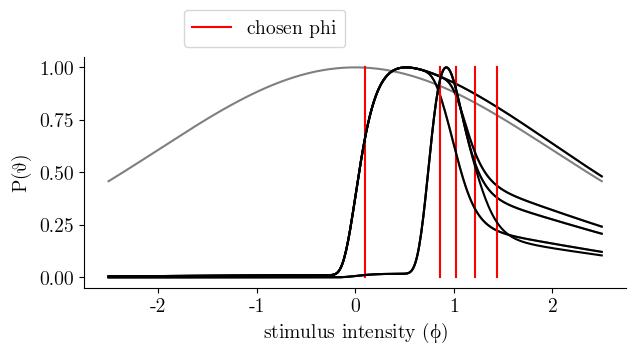

In [21]:

tActual = 1.5 # ground truth
tGuess = 0.1 # chance level

tGuessSd = 2.0 # sd of Gaussian before clipping to specified range
pThreshold = 0.82
beta = 3.5
delta = 0.01
gamma = 0.5
q=QuestObject(tGuess,tGuessSd,pThreshold,beta,delta,gamma)

# Simulate a series of trials.
trialsDesired=5
wrongRight = 'wrong', 'right'

for k in range(trialsDesired):
    # Get recommended level.  Choose your favorite algorithm.
    # tTest=q.quantile()
    tTest=q.mean()
    # tTest=q.mode()
    plt.plot(q.x,q.pdf/max(q.pdf), color='k', alpha=0.5)
    plt.plot([tTest,tTest],[0,max(q.pdf/max(q.pdf))], color='red', label=r'chosen $phi$')

    # tTest=tTest+random.choice([-0.1,0,0.1])

    # Simulate a trial
    response=int(q.simulate(tTest,tActual))
    print('Trial %3d at %4.1f is %s'%(k+1,tTest,wrongRight[int(response)]))

    # Update the pdf
    q.update(tTest,response)
    plt.plot(q.x,q.pdf/max(q.pdf), color='k', alpha=1)
    # plt.title(response)
    plt.xlabel(r'stimulus intensity ($\phi$)')
    plt.ylabel(r'$P(\theta)$')
    quickspine(plt.gca())
    quickleg(plt.gca(), bbox_to_anchor=(0.5,1))
    




--- Running 5 Quest Trials ---
Trial   1 at   0.10 is right (True Θ=1.5)
Trial   2 at  -0.26 is wrong (True Θ=1.5)
Trial   3 at   0.87 is right (True Θ=1.5)
Trial   4 at   0.65 is wrong (True Θ=1.5)
Trial   5 at   1.43 is right (True Θ=1.5)


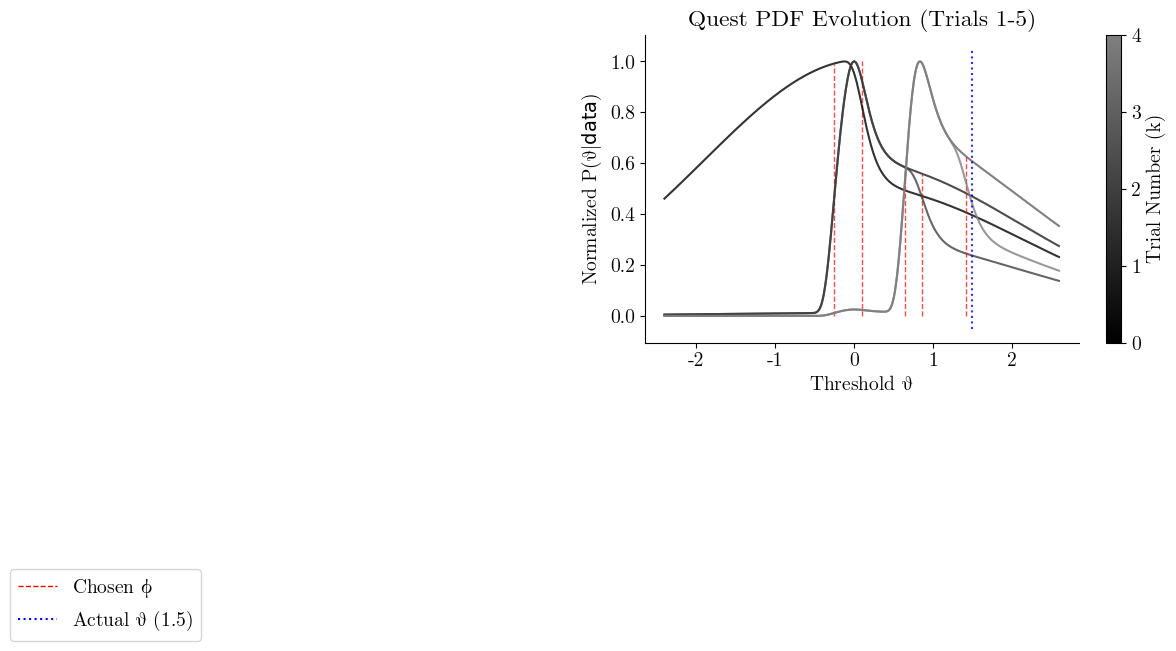

In [27]:
# --- Make sure these imports are included at the top of your script ---
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, Normalize
# Assuming QuestObject class is defined as before
# Assuming plot_ult functions (quickspine, quickleg) are available or defined

# --- Parameters (as provided in your snippet) ---
tActual = 1.5 # ground truth
tGuess = 0.1 # initial guess

tGuessSd = 2.0 # sd of Gaussian before clipping to specified range
pThreshold = 0.82
beta = 3.5
delta = 0.01
gamma = 0.5
q = QuestObject(tGuess, tGuessSd, pThreshold, beta, delta, gamma)

# Simulate a series of trials.
trialsDesired = 5 # k will go from 0 to 4
wrongRight = 'wrong', 'right'

# --- Setup Color Gradient ---
k_max = trialsDesired - 1
max_grey_level = 0.5 # Black (0.0) to this grey level (0.3)
N_colors = 256 # Standard number of colors in a colormap
colors_subset = cm.gray(np.linspace(0, max_grey_level, N_colors))
pdf_cmap = ListedColormap(colors_subset)
pdf_norm = Normalize(vmin=0, vmax=k_max)

# --- Create Figure and Axes for the plot ---
# If using plot_ult:
# with initiate_plot(7, 4, 150) as fig:
#    ax = fig.add_subplot(111)
# If using plain matplotlib:
fig, ax = plt.subplots(figsize=(7, 4))

print(f"--- Running {trialsDesired} Quest Trials ---")
for k in range(trialsDesired):
    # Get recommended level (e.g., mean)
    tTest = q.mean()

    # --- Plot vertical line for the chosen stimulus (tTest) ---
    # Plot before the update, use PDF height before update for scaling y-max
    pdf_max_before = np.max(q.pdf) if np.max(q.pdf) > 0 else 1.0
    # Find the PDF value near tTest (relative to tGuess)
    pdf_val_at_tTest = q.pdf[find_nearest(q.x, tTest-q.tGuess)] # Use find_nearest helper function
    ax.plot([q.tGuess + (tTest-q.tGuess), q.tGuess + (tTest-q.tGuess)], # Use absolute coords: tGuess + x = theta scale
             [0, pdf_val_at_tTest / pdf_max_before], # Scale line height
             color='red', linestyle='--', alpha=0.7, lw=1.0,
             label='Chosen $\phi$' if k == 0 else "") # Label only on first iteration

    # Simulate a trial
    # Make sure 'random' is imported if you uncomment the line below
    # tTest_noisy = tTest + random.choice([-0.1, 0, 0.1]) # Optional noise
    response = int(q.simulate(tTest, tActual)) # Use original tTest for simulation
    print(f'Trial {k+1:3d} at {tTest:6.2f} is {wrongRight[response]} (True Θ={tActual})')

    # Update the pdf state
    q.update(tTest, response) # Update with original tTest

    # --- Plot the updated PDF using the gradient color ---
    # Normalize PDF for plotting (scale max to 1)
    pdf_max_after = np.max(q.pdf)
    if pdf_max_after > 1e-9: # Avoid division by zero or tiny numbers
        pdf_to_plot = q.pdf / pdf_max_after
    else:
        pdf_to_plot = q.pdf # Plot as is if max is zero/very small

    plot_color = pdf_cmap(pdf_norm(k)) # Get color for this iteration k

    # Plot PDF on absolute theta scale (tGuess + x)
    ax.plot(q.tGuess + q.x,
            pdf_to_plot,
            color=plot_color,
            alpha=0.8,  # Adjust alpha for visibility if lines overlap heavily
            lw=1.5)     # Slightly thicker line might help

# --- Final plot adjustments (after loop) ---
ax.set_xlabel(r'Threshold $\theta$') # X-axis represents possible threshold values
ax.set_ylabel(r'Normalized $P(\theta | \mathrm{data})$') # Y-axis is normalized posterior
ax.set_title(f'Quest PDF Evolution (Trials 1-{trialsDesired})')

# Add a line for the actual threshold
ax.plot([tActual, tActual], ax.get_ylim(), color='blue', linestyle=':', alpha=0.8, label=f'Actual $\\theta$ ({tActual:.1f})')

# Add a colorbar to show the trial progression mapping
sm = plt.cm.ScalarMappable(cmap=pdf_cmap, norm=pdf_norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label='Trial Number (k)')

# Apply styling and legend
quickspine(ax) # Use your function
quickleg(ax, loc='upper left') # Or ax.legend()

# Ensure plot is displayed
# plt.show() # Call this after setting up all plots if not using 'with initiate_plot'

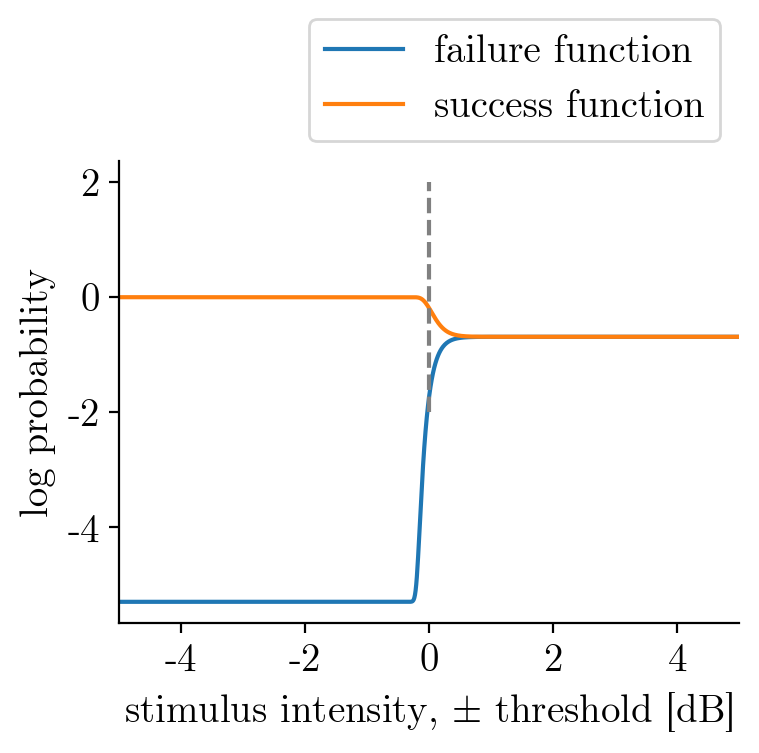

In [28]:

# scucess and failure function plot --------
with initiate_plot(4,3,200) as f:
    ax=f.add_subplot(111)
    plt.plot(q.x2,np.log(q.s2[0,:]),label='failure function')
    plt.plot(q.x2,np.log(q.s2[1,:]),label='success function')
    plt.plot([0,0],[-2,2],'--', color='grey')
    plt.xlim(-5,5)
    # plt.ylim(-0.1,1.1)
    quickleg(ax, bbox_to_anchor=[1,1])
    quickspine(ax)
    plt.xlabel(r'stimulus intensity, $\pm$ threshold [dB]')
    plt.ylabel('log probability')



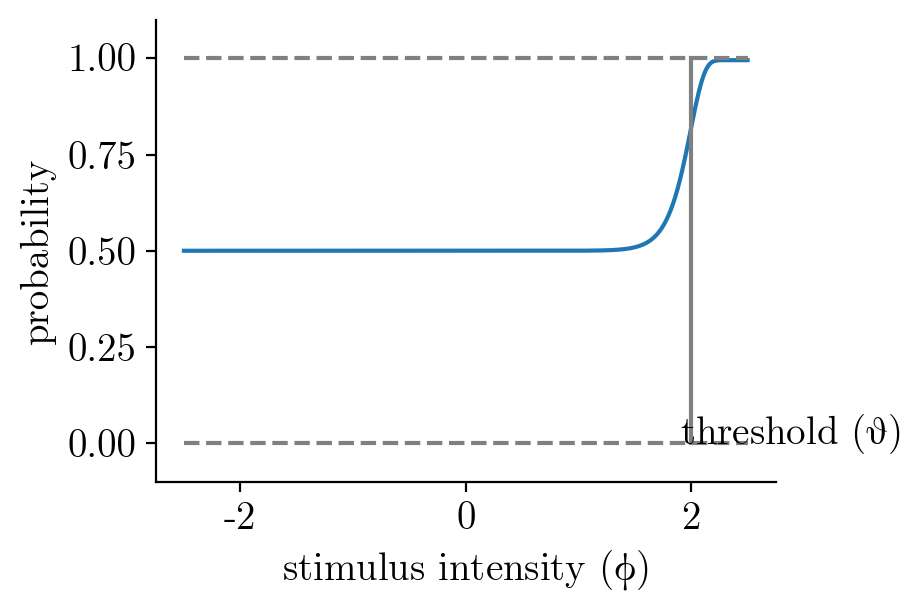

In [9]:

# psychometric function plot -------
with initiate_plot(4,3,200) as f:
    ax=f.add_subplot(111)
    plt.plot(q.x,[q.simulate_p(x, tActual) for x in q.x],label='psychometric function')
    plt.xlabel(r'stimulus intensity ($\phi$)')
    plt.ylabel('probability')
    plt.ylim(-0.1,1.1)
    plt.plot(q.x, np.zeros_like(q.x), '--', color='grey')
    plt.plot(q.x, np.ones_like(q.x), '--', color='grey')
    plt.plot([tActual,tActual],[0,1], '-', color='grey')
    plt.text(tActual-0.1,0,r'threshold ($\theta$)')
    quickspine(ax)




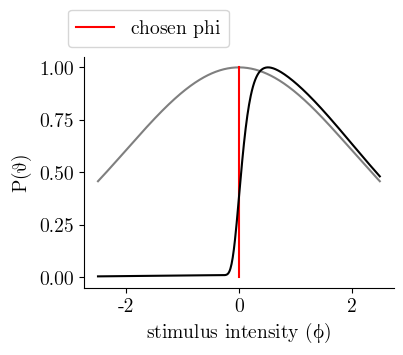

In [10]:

q=QuestObject(tGuess,tGuessSd,pThreshold,beta,delta,gamma)

# tTest=q.mean()
tTest=q.mode()
plt.plot(q.x,q.pdf/max(q.pdf), color='k', alpha=0.5)
plt.plot([tTest,tTest],[0,max(q.pdf/max(q.pdf))], color='red', label=r'chosen $phi$')
response=int(q.simulate(tTest,tActual))
q.update(tTest,response)
plt.plot(q.x,q.pdf/max(q.pdf), color='k', alpha=1)
# plt.title(response)
plt.xlabel(r'stimulus intensity ($\phi$)')
plt.ylabel(r'$P(\theta)$')
quickspine(plt.gca())
quickleg(plt.gca(), bbox_to_anchor=(0.5,1))
plt.show()


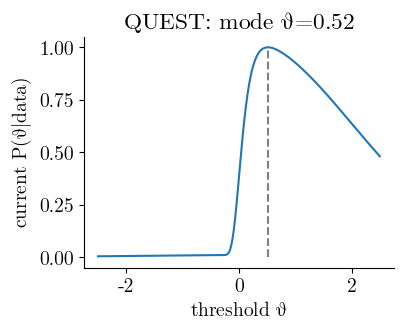

In [12]:

def dd(theta, phi):
    # double derivative dpsi/d2theta
    t=theta
    dd=-(k *(phi/t)**k *(1 + k + np.exp((phi/t)**k) *(-1 + k* (-1 + (phi/t)**k))))/((-1 + np.exp((phi/t)**k))**2 *t**2)    
    return dd


q=q
Is=[]
for phi in q.x:
    # I=sum([(0.75-q.simulate_p(phi,theta))**2*priorp for priorp,theta in zip(q.pdf/sum(q.pdf),q.x)])
    # I=np.nanmean([dd(theta,phi)*priorp for priorp,theta in zip(q.pdf/sum(q.pdf),q.x)])
    # I=np.sum([(theta,phi)*priorp for priorp,theta in zip(q.pdf/sum(q.pdf),q.x)])
    psy=delta*gamma+(1-delta)*(1-(1-gamma)*np.exp(-10**(beta*(q.x))))
    I0=(np.diff(psy)**2)/((psy*(1-psy))[1:]) # information of delta phi-theta, the kernel
    priortheta=q.pdf/sum(q.pdf)
    conv=np.convolve(priortheta,I0)[len(q.x)//2:-(len(q.x)//2)]
    I=np.sum(conv
             )
    # plt.plot(conv)
    # len(conv)
    # len(priortheta)
    # len(I0)
    # psy=delta*gamma+(1-delta)*(1-(1-gamma)*np.exp(-10**(beta*(q.x))))
    # plt.plot(psy)
    # plt.plot(I0)

    # phi=-1
    # # plt.plot(q.x, dd(q.x,phi))
    # plt.plot(q.x, q.pdf/sum(q.pdf))
    # plt.plot(q.x, dd(q.x,phi)*q.pdf/sum(q.pdf))
    # # plt.plot(q.x,[dd(theta,phi) for priorp,theta in zip(q.pdf/sum(q.pdf),q.x)])
    # plt.plot(q.x,[priorp for priorp,theta in zip(q.pdf/sum(q.pdf),q.x)])
    # plt.plot(q.x,[dd(theta,phi)*priorp for priorp,theta in zip(q.pdf/sum(q.pdf),q.x)])

    Is.append(I)
psy=delta*gamma+(1-delta)*(1-(1-gamma)*np.exp(-10**(beta*(q.x))))
I0=(np.diff(psy)**2)/((psy*(1-psy))[1:]) # information of delta phi-theta, the kernel
priortheta=q.pdf/sum(q.pdf)
conv=np.convolve(priortheta,I0)[len(q.x)//2:-(len(q.x)//2)]
bestphi=q.x[np.argmax(conv)]

# current theta estimation
plt.plot(q.x,q.pdf/max(q.pdf))
plt.xlabel(r'threshold $\theta$')
plt.ylabel(r'current $P(\theta|data)$')
plt.title(r'QUEST: mode $\theta$={:.2f}'.format(q.mode()))
plt.plot([q.mode(),q.mode()],[0,1], '--', color='grey')
quickspine(plt.gca())
plt.show()

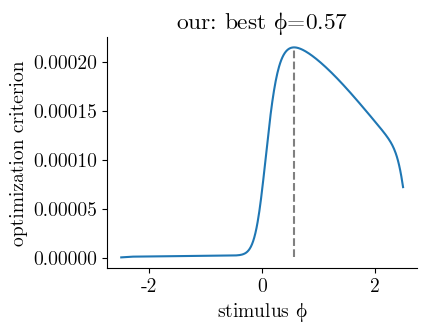

In [13]:
# best phi--------
psy=delta*gamma+(1-delta)*(1-(1-gamma)*np.exp(-10**(beta*(q.x))))
I0=(np.diff(psy)**2)/((psy*(1-psy))[1:])
priortheta=q.pdf/sum(q.pdf)
conv=np.convolve(priortheta,I0)[len(q.x)//2:-(len(q.x)//2-1)]
bestphi=q.x[np.argmax(conv)]
plt.plot(q.x,conv)
plt.plot([bestphi,bestphi],[min(conv), max(conv)], '--', color='grey')
plt.xlabel(r'stimulus $\phi$')
plt.ylabel(r'optimization criterion')
plt.title(r'our: best $\phi$={:.2f}'.format(bestphi))
quickspine(plt.gca())


--- Running Comparison: Quest vs 'Our' (55 trials, True Θ=1.0) ---


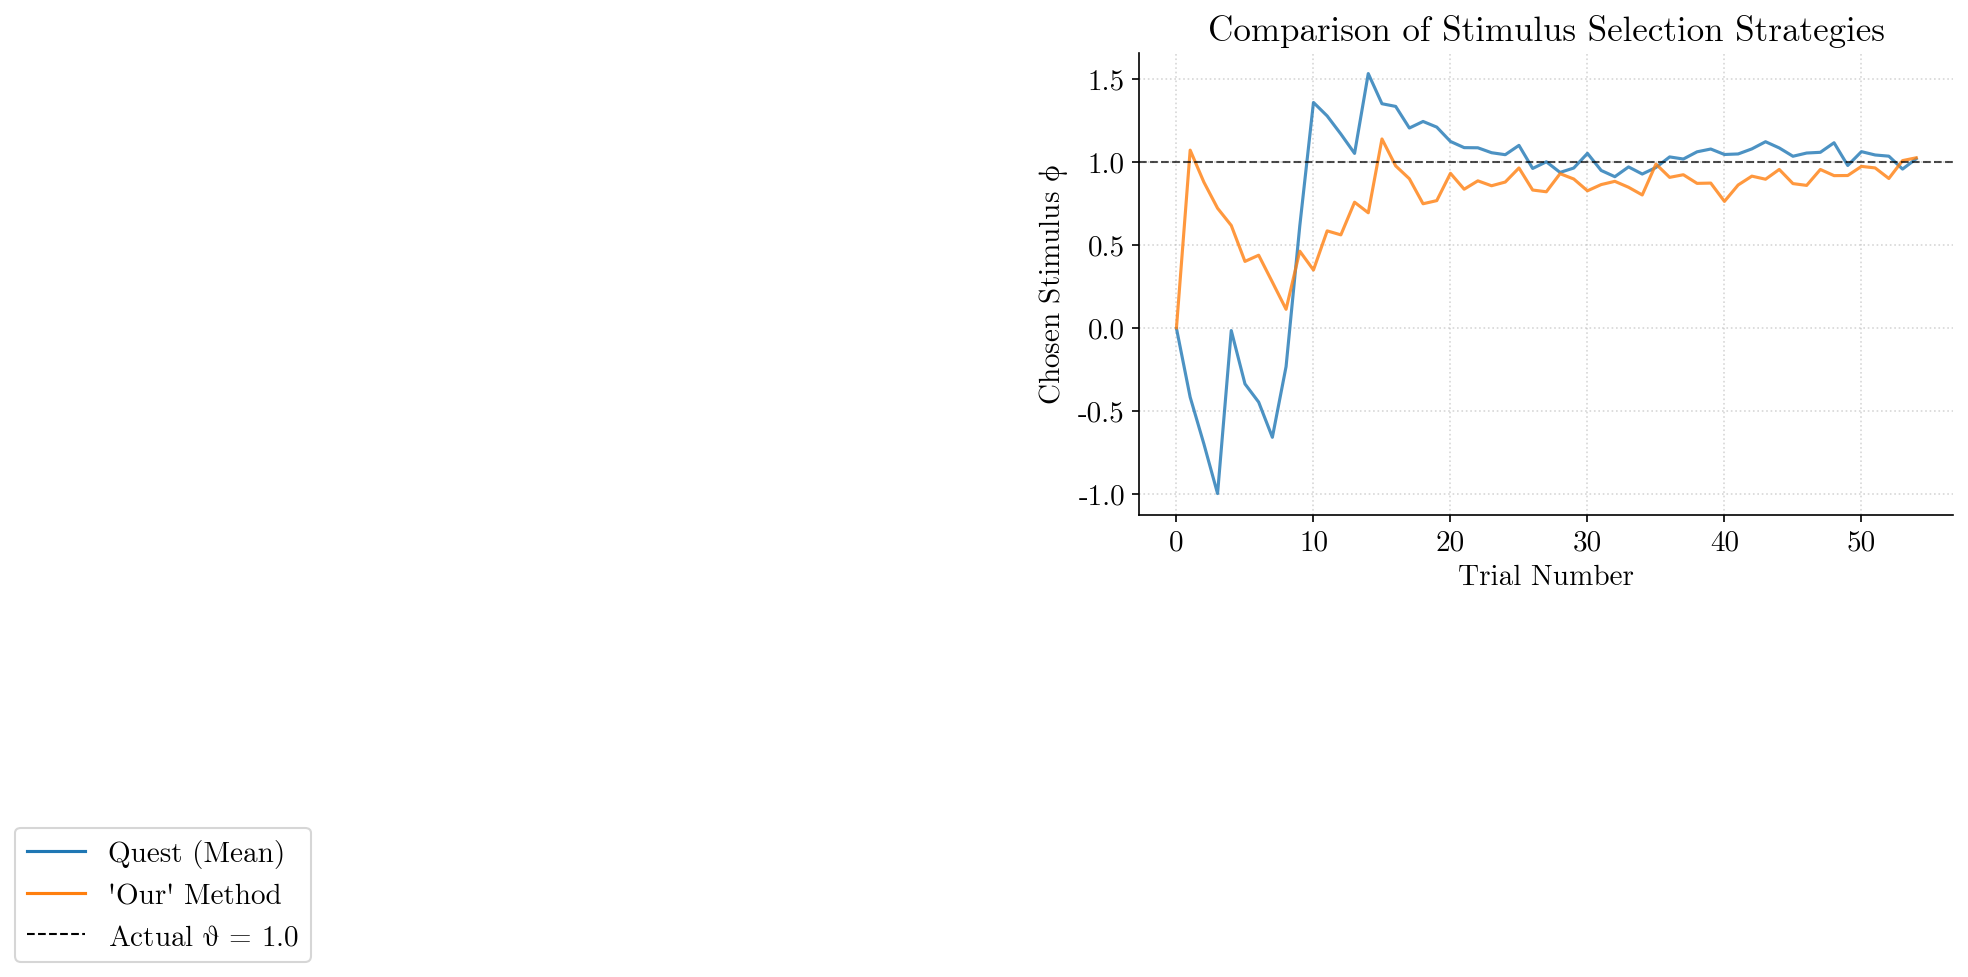

In [30]:
# --- Make sure these imports are included ---
import numpy as np
import matplotlib.pyplot as plt
# Assuming QuestObject class is defined as before
# Assuming plot_ult functions (initiate_plot, quickspine, quickleg) are available

# --- Parameters (as provided in your snippet) ---
tActual_comp = 1.0 # Ground truth for this comparison simulation
tGuess = 0.0 # Initial guess
tGuessSd = 2.0 # Prior SD
pThreshold = 0.82
beta = 3.5
delta = 0.01
gamma = 0.5
noise = 0.05
num_comparison_trials = 55 # Number of steps

# --- Comparison Loop (Data Generation - unchanged from your snippet) ---
print(f"--- Running Comparison: Quest vs 'Our' ({num_comparison_trials} trials, True Θ={tActual_comp}) ---")
q1 = QuestObject(tGuess, tGuessSd, pThreshold, beta, delta, gamma) # Quest (mean)
q2 = QuestObject(tGuess, tGuessSd, pThreshold, beta, delta, gamma) # Our method

phis1 = [] # History of phis chosen by Quest
phis2 = [] # History of phis chosen by 'Our' method

for i in range(num_comparison_trials):
    # --- q1 (Quest Mean) Update ---
    tTest1 = q1.mean()
    # tTest=q1.quantile() # Alternative
    tTest1 = tTest1 + (np.random.normal() * noise) # Add noise
    response1 = int(q1.simulate(tTest1, tActual_comp))
    q1.update(tTest1, response1)
    phis1.append(tTest1)

    # --- q2 ('Our' Method - Convolution) Update ---
    # Note: This calculation assumes q2.x grid matches necessary convolutions.
    # It might be more robust to use the interpolation method shown in
    # the calculate_expected_info function from previous examples if available.

    # Calculate psychometric function based on current q2 params (needed for I0)
    # Assuming delta, gamma, beta are accessible here
    psy0 = delta * gamma + (1 - delta) * (1 - (1 - gamma) * np.exp(-10**(beta * (q2.x))))

    # Calculate Fisher Info kernel I0 = (d(psy)/dx)^2 / (psy*(1-psy))
    # Use np.gradient for derivative, handle edges and division by zero
    dp_dx = np.gradient(psy0, q2.x, edge_order=2)
    denominator = psy0 * (1 - psy0)
    eps = 1e-9 # Avoid division by zero
    I0 = dp_dx**2 / np.maximum(denominator, eps)
    # Often more stable to use I0 corresponding to internal points, excluding edges
    I0_valid = I0[1:-1]
    x_valid = q2.x[1:-1] # Corresponding x values for I0_valid

    # Get current prior PDF from q2
    pdf_sum = np.sum(q2.pdf)
    if pdf_sum > eps:
        priortheta = q2.pdf / pdf_sum
    else:
        # Handle case where PDF sum is zero (e.g., uniform fallback)
        priortheta = np.ones_like(q2.pdf) / len(q2.pdf)
        print(f"Warning: q2 PDF sum zero at trial {i+1}. Using uniform prior for convolution.")

    # Perform convolution: Expected_Info(phi) = integral[ P(theta) * I0(phi-theta) ] dtheta
    # This is P(theta) convolved with I0(-theta) evaluated at phi.
    # Need to ensure I0 is defined on a grid compatible with priortheta for np.convolve
    # Using the original slicing approach (with caution):
    # Assume I0 used should match priortheta length? This might need recalculation of I0 on q2.x grid.
    # If using I0_valid calculated above:
    if len(priortheta) > len(I0_valid):
         # Convolve with flipped I0 (corresponds to I0(-delta_t))
         conv_full = np.convolve(priortheta, I0_valid[::-1], mode='full')
         # Calculate center part - requires careful index mapping based on mode='full'
         # A potentially simpler/more robust approach is direct expectation calculation (see previous answers)
         # Sticking to original code's *apparent* intent (might be flawed):
         start_idx = len(I0_valid) // 2 # Adjust based on lengths and mode
         end_idx = start_idx + len(priortheta)
         # This index mapping needs verification based on desired alignment.

         # Fallback to original slicing if desperate, but it's likely incorrect unless I0 has specific length relation
         start_idx_orig = len(q2.x) // 2
         end_idx_orig = len(conv_full) - (len(q2.x)//2 -1) if (len(q2.x)//2 -1) > 0 else len(conv_full)
         conv_segment = conv_full[start_idx_orig:end_idx_orig]

         if len(conv_segment) == len(q2.x): # Check if length matches expected grid
             best_idx = np.argmax(conv_segment)
             tTest2 = q2.x[best_idx] + q2.tGuess # Convert back to absolute theta/phi scale
         elif len(conv_segment) > 0:
             print(f"Warning: Convolution output length mismatch at trial {i+1}. Using peak of segment.")
             best_idx_seg = np.argmax(conv_segment)
             # Need to map best_idx_seg back to q2.x index - highly unreliable without proper alignment
             tTest2 = q2.mean() # Safer fallback
         else:
             print(f"Warning: Convolution output empty at trial {i+1}. Falling back to mean.")
             tTest2 = q2.mean()

    else:
        print(f"Warning: Prior PDF length <= I0 length at trial {i+1}. Convolution setup problematic. Falling back to mean.")
        tTest2 = q2.mean() # Fallback if convolution setup is problematic

    # Add noise
    tTest2 = tTest2 + (np.random.normal() * noise)
    # Simulate and update q2
    response2 = int(q2.simulate(tTest2, tActual_comp))
    q2.update(tTest2, response2)
    phis2.append(tTest2)


# --- Plotting Section (Revised Single Plot) ---
with initiate_plot(7, 4, 150) as f:  # Adjust figure size for single plot
    ax = f.add_subplot(111)  # Create a single axes object

    # Plot Quest (Mean) stimulus history
    ax.plot(range(num_comparison_trials), phis1, label='Quest (Mean)', alpha=0.8, color='tab:blue', lw=1.5)

    # Plot 'Our' Method stimulus history
    ax.plot(range(num_comparison_trials), phis2, label="'Our' Method", alpha=0.8, color='tab:orange', lw=1.5)

    # Plot Actual Theta line
    ax.axhline(tActual_comp, color='black', linestyle='--', linewidth=1.0, label=f'Actual $\\theta$ = {tActual_comp:.1f}', alpha=0.7)

    # --- Polish the plot ---
    ax.set_xlabel('Trial Number')
    ax.set_ylabel(r'Chosen Stimulus $\phi$')
    ax.set_title('Comparison of Stimulus Selection Strategies')
    ax.grid(True, linestyle=':', alpha=0.5)  # Add a light grid
    # Optional: Set Y-axis limits for better focus if needed
    # ylim_lower = min(min(phis1), min(phis2), tActual_comp) - 0.5
    # ylim_upper = max(max(phis1), max(phis2), tActual_comp) + 0.5
    # ax.set_ylim([ylim_lower, ylim_upper])

    quickspine(ax)  # Apply your spine settings
    quickleg(ax, loc='best')  # Add legend in a good location

    plt.tight_layout() # Adjust layout to prevent labels overlapping

# --- Display the plot ---
# plt.show() # Uncomment if not using interactive mode or if plt.show() is needed

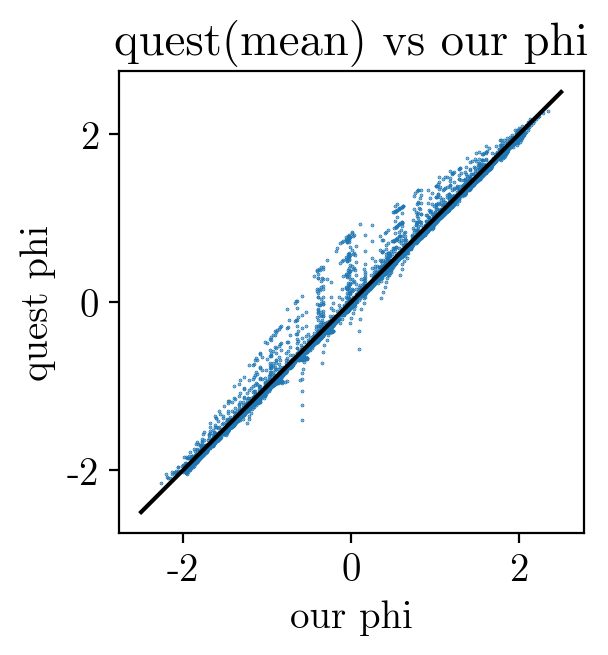

In [15]:

# compare the best phi given same history
phis1=[]
phis2=[]
noise=0.05
for tActual in np.linspace(-2,2,100): # number of tasks
    q1=QuestObject(tGuess,tGuessSd,pThreshold,beta,delta,gamma)
    for i in range(55): # number of trials per task
        # quest selection
        tTest=q1.mean()
        # tTest=q1.quantile()
        # tTest=q1.mode()
        phis1.append(tTest)

        # our selection
        psy0=delta*gamma+(1-delta)*(1-(1-gamma)*np.exp(-10**(beta*(q1.x))))
        I0=(np.diff(psy0)**2)/((psy0*(1-psy0))[1:])
        priortheta=q1.pdf/sum(q1.pdf)
        conv=np.convolve(priortheta,I0)[len(q1.x)//2:-(len(q1.x)//2-1)]
        tTest2=q1.x[np.argmax(conv)] # selected best phi
        phis2.append(tTest2)
    
        tTest=tTest+(np.random.normal()*noise)
        response=int(q1.simulate(tTest,tActual))
        q1.update(tTest,response)
        
with initiate_plot(3,3,200) as f:
    ax1=f.add_subplot(111)
    ax1.set_ylabel('quest phi')
    ax1.set_xlabel('our phi')
    ax1.set_title('quest(mean) vs our phi')
    ax1.scatter(phis2,phis1, s=0.1)
    plt.axis('equal')
    plt.xlim([-2,2])
    ax1.plot([-2.5,2.5],[-2.5,2.5], color='black')




Trial   5 at  0.4 is wrong


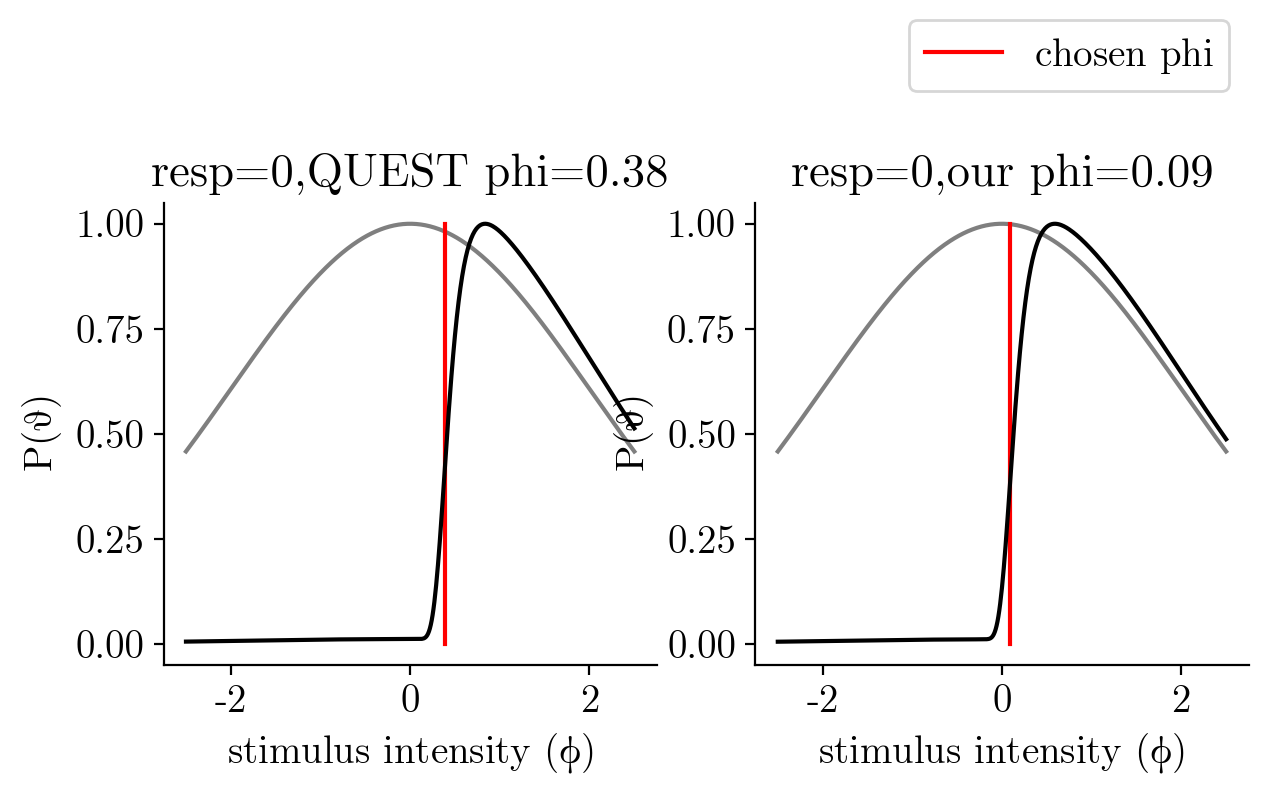

In [19]:

q1=QuestObject(tGuess,tGuessSd,pThreshold,beta,delta,gamma)
q2=QuestObject(tGuess,tGuessSd,pThreshold,beta,delta,gamma)
with initiate_plot(7,3,200) as f:
    ax1=f.add_subplot(1,2,1)
    ax2=f.add_subplot(1,2,2)

    ax1.plot(q1.x,q1.pdf/max(q1.pdf), color='k', alpha=0.5)

    # q1 update
    tTest=q1.quantile()
    tTest=tTest+(np.random.normal()*noise)
    response=int(q1.simulate(tTest,tActual))
    print('Trial %3d at %4.1f is %s'%(k+1,tTest,wrongRight[int(response)]))
    q1.update(tTest,response)

    ax1.plot([tTest,tTest],[0,max(q1.pdf/max(q1.pdf))], color='red', label=r'chosen $phi$')
    ax1.plot(q1.x,q1.pdf/max(q1.pdf), color='k', alpha=1)
    ax1.set_title('resp={},QUEST phi={:.2f}'.format(response,tTest))
    ax1.set_xlabel(r'stimulus intensity ($\phi$)')
    ax1.set_ylabel(r'$P(\theta)$')
    quickspine(ax1)


    ax2.plot(q2.x,q2.pdf/max(q2.pdf), color='k', alpha=0.5)
    # # q2 update
    # Is=[]
    # for phi in q2.x:
    #     I=sum([(0.75-q2.simulate_p(phi,theta))**2*priorp for priorp,theta in zip(q2.pdf/sum(q2.pdf),q2.x)])
    #     Is.append(I)
    # tTest=q2.x[np.argmin(Is)]
    # tTest=tTest+(np.random.normal()*noise)
    # response=int(q2.simulate(tTest,tActual))
    # q2.update(tTest,response)

    # q2 update 0504
    psy0=delta*gamma+(1-delta)*(1-(1-gamma)*np.exp(-10**(beta*(q2.x))))
    I0=(np.diff(psy0)**2)/((psy0*(1-psy0))[1:])
    priortheta=q2.pdf/sum(q2.pdf)
    conv=np.convolve(priortheta,I0)[len(q2.x)//2:-(len(q2.x)//2-1)]
    # plt.plot(q.x,psy)
    # plt.plot(q.x[1:],I0)
    # plt.plot(q.x,conv)
    tTest=q2.x[np.argmax(conv)] # selected best phi
    tTest=tTest+(np.random.normal()*noise)
    response=int(q2.simulate(tTest,tActual))
    q2.update(tTest,response)



    ax2.plot([tTest,tTest],[0,max(q2.pdf/max(q2.pdf))], color='red', label=r'chosen $phi$')
    ax2.plot(q2.x,q2.pdf/max(q2.pdf), color='k', alpha=1)
    ax2.set_title('resp={},our phi={:.2f}'.format(response,tTest))
    ax2.set_xlabel(r'stimulus intensity ($\phi$)')
    ax2.set_ylabel(r'$P(\theta)$')
    quickspine(ax2)
    quickleg(ax2, bbox_to_anchor=(1,1.2))







--- Running Original Quest Simulation (Modified PDF Plot) ---
Trial   1 at   0.10 is right (True Θ=1.5)
Trial   2 at   0.10 is wrong (True Θ=1.5)
Trial   3 at   0.10 is wrong (True Θ=1.5)
Trial   4 at   0.10 is right (True Θ=1.5)
Trial   5 at   0.10 is wrong (True Θ=1.5)
Trial   6 at   0.10 is wrong (True Θ=1.5)
Trial   7 at   0.10 is right (True Θ=1.5)
Trial   8 at   0.10 is right (True Θ=1.5)
Trial   9 at   0.10 is right (True Θ=1.5)
Trial  10 at   0.10 is right (True Θ=1.5)
Trial  11 at   0.10 is right (True Θ=1.5)
Trial  12 at   0.10 is wrong (True Θ=1.5)
Trial  13 at   0.10 is right (True Θ=1.5)
Trial  14 at   0.10 is wrong (True Θ=1.5)
Trial  15 at   0.10 is right (True Θ=1.5)
Trial  16 at   0.10 is wrong (True Θ=1.5)
Trial  17 at   0.10 is wrong (True Θ=1.5)
Trial  18 at   0.10 is right (True Θ=1.5)
Trial  19 at   0.10 is wrong (True Θ=1.5)
Trial  20 at   0.10 is right (True Θ=1.5)


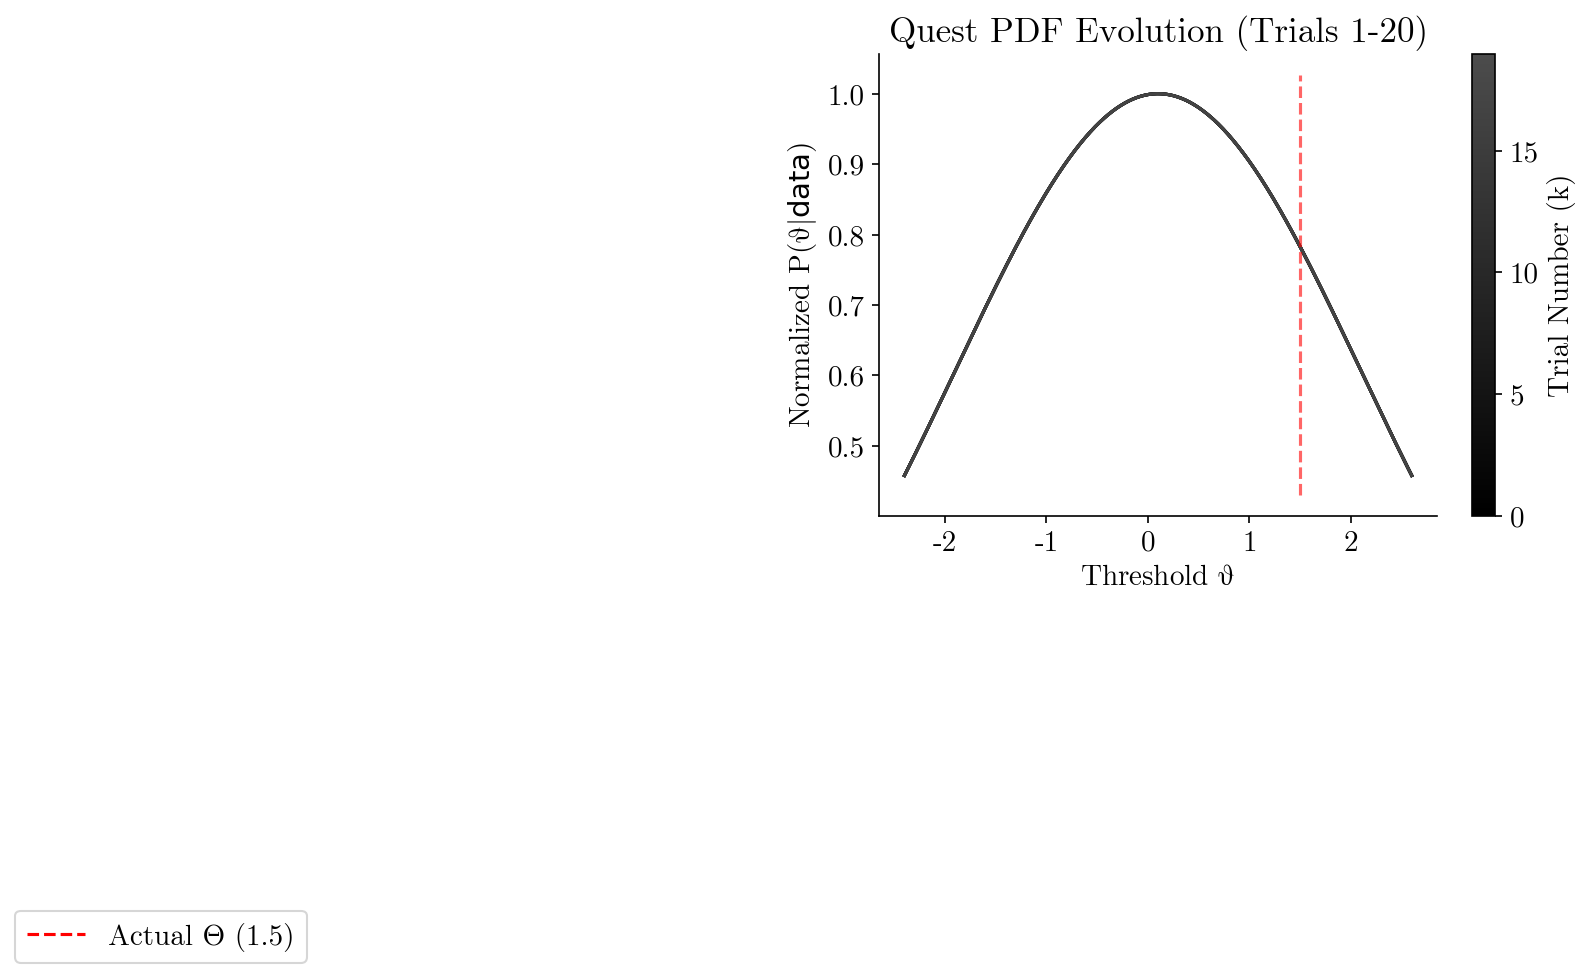

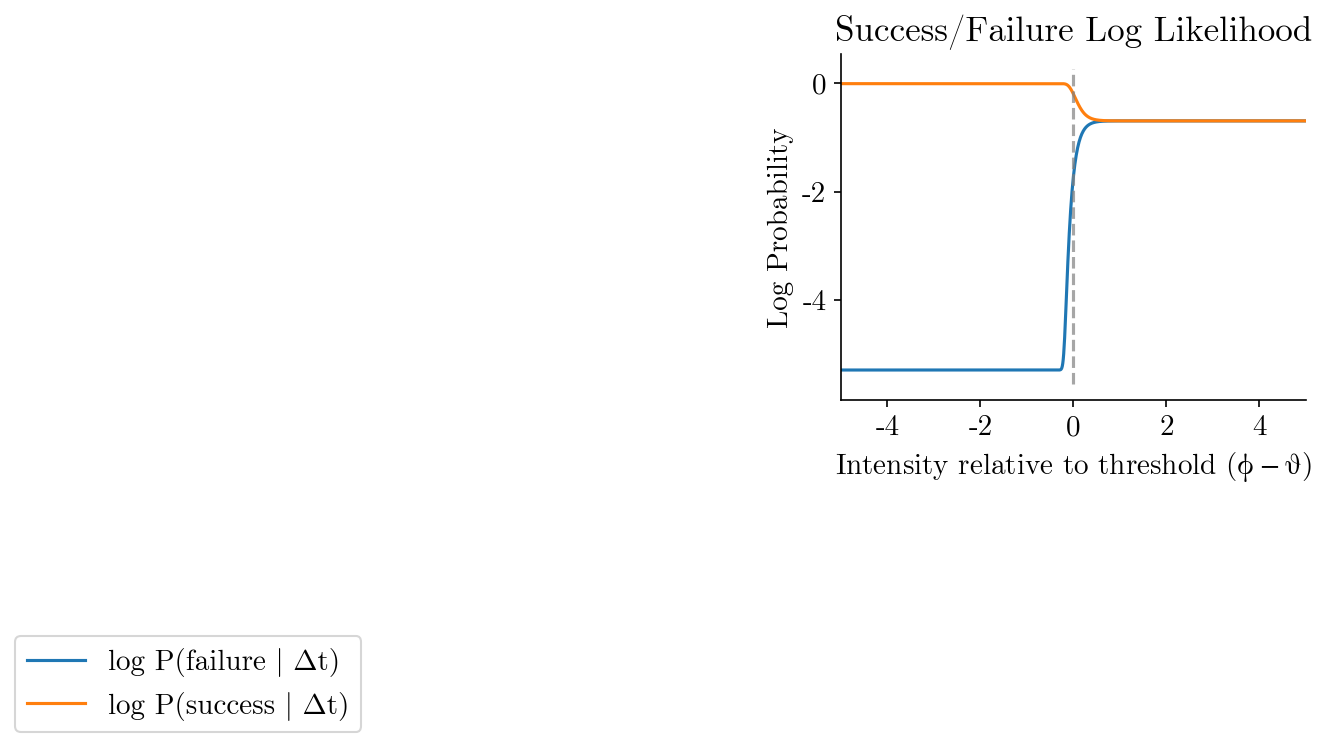

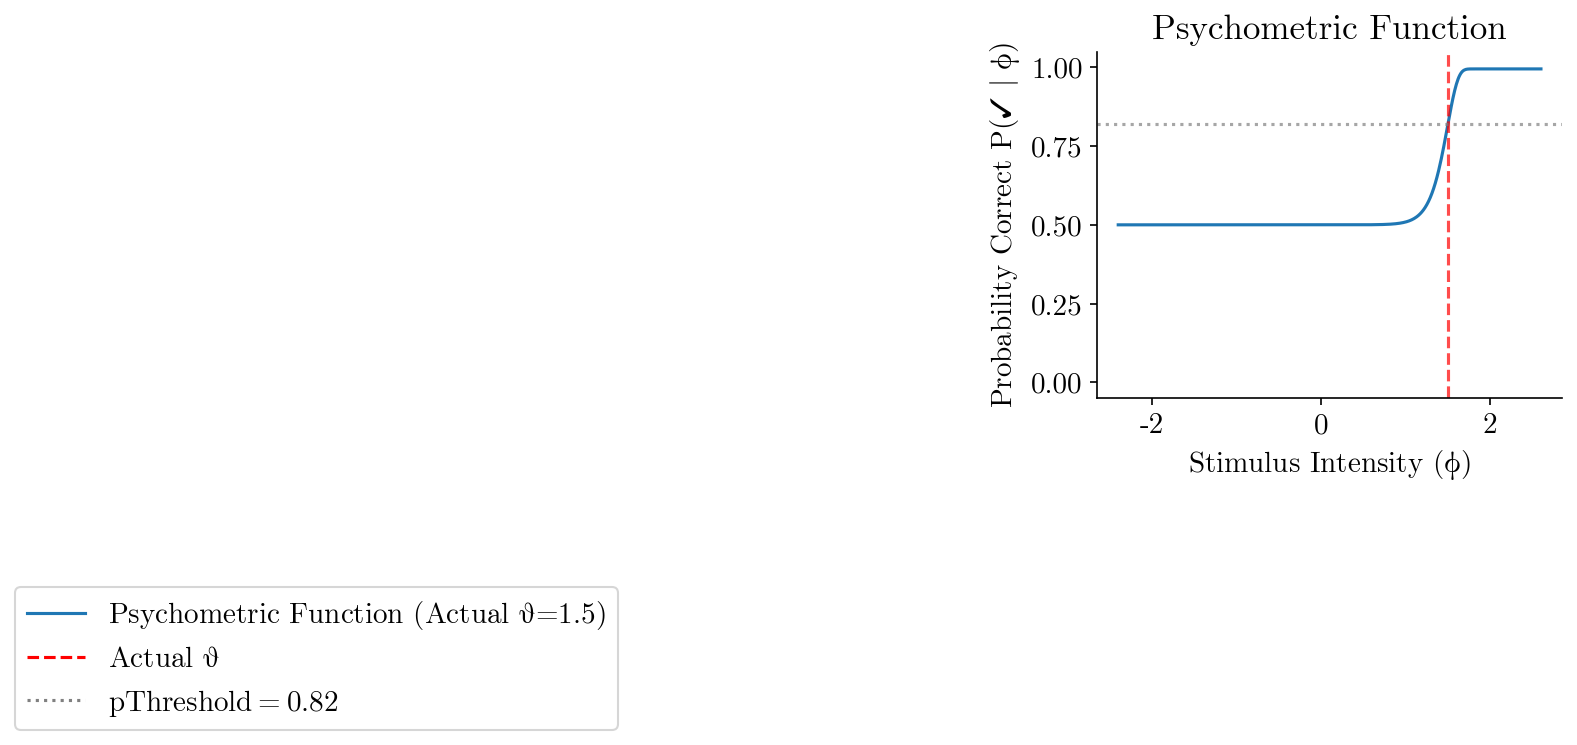

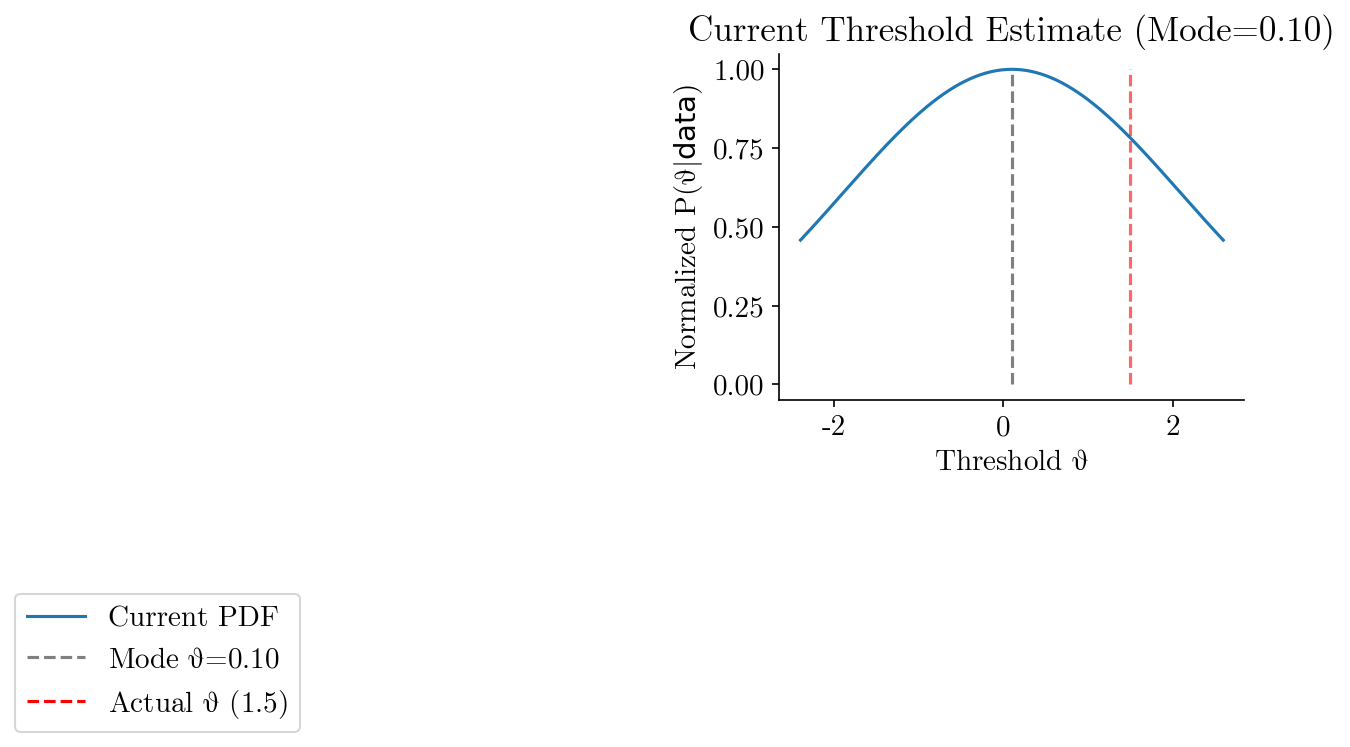

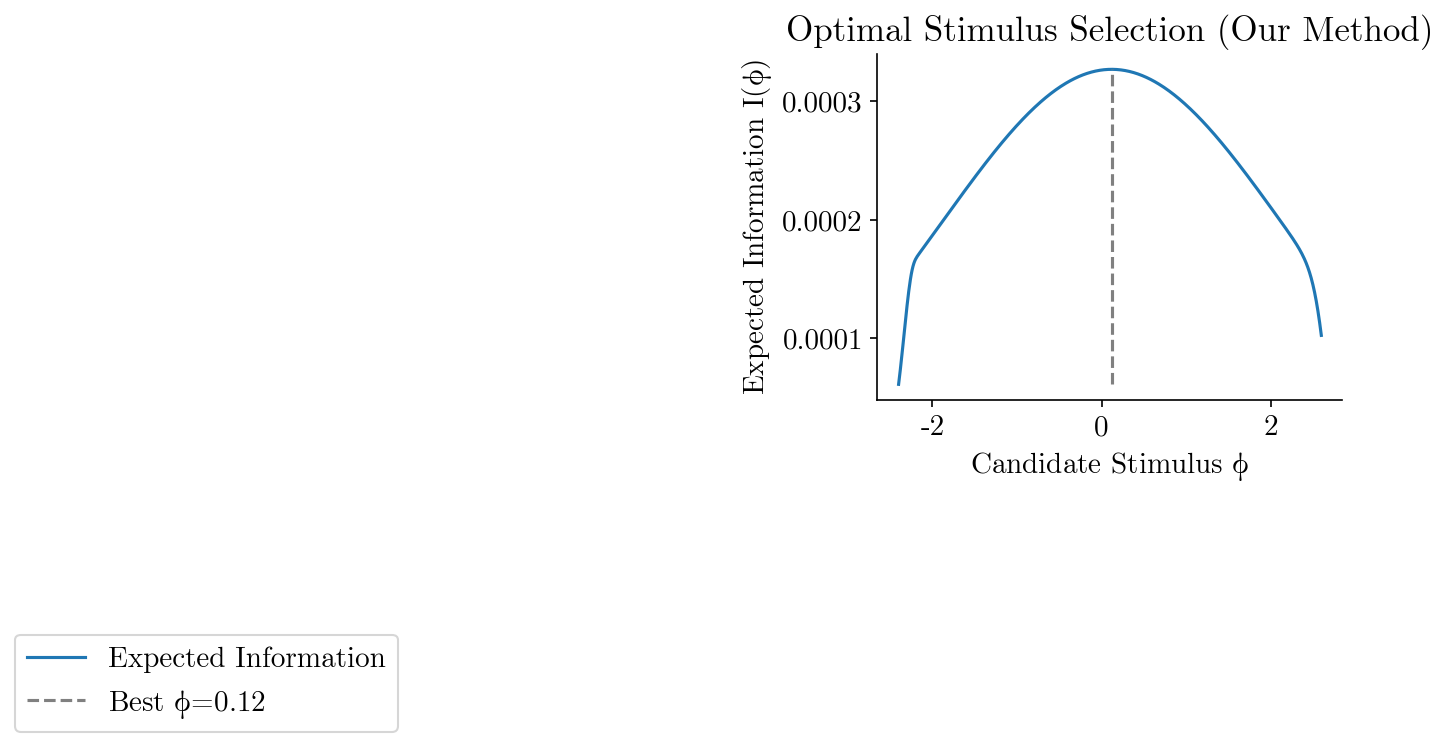


--- Running Comparison: Quest vs 'Our' (55 trials) ---


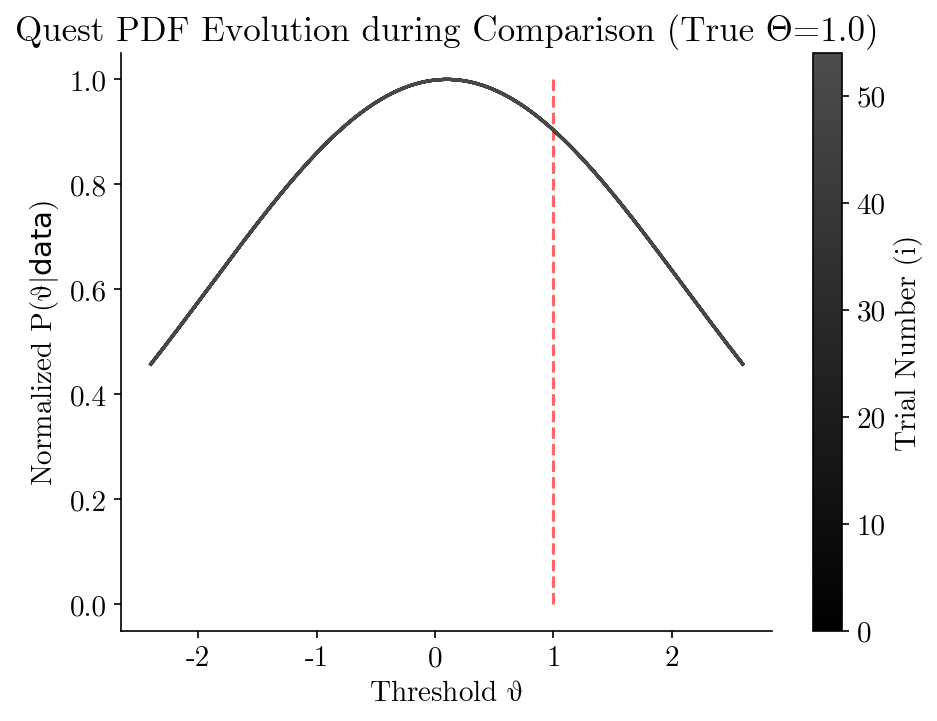

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


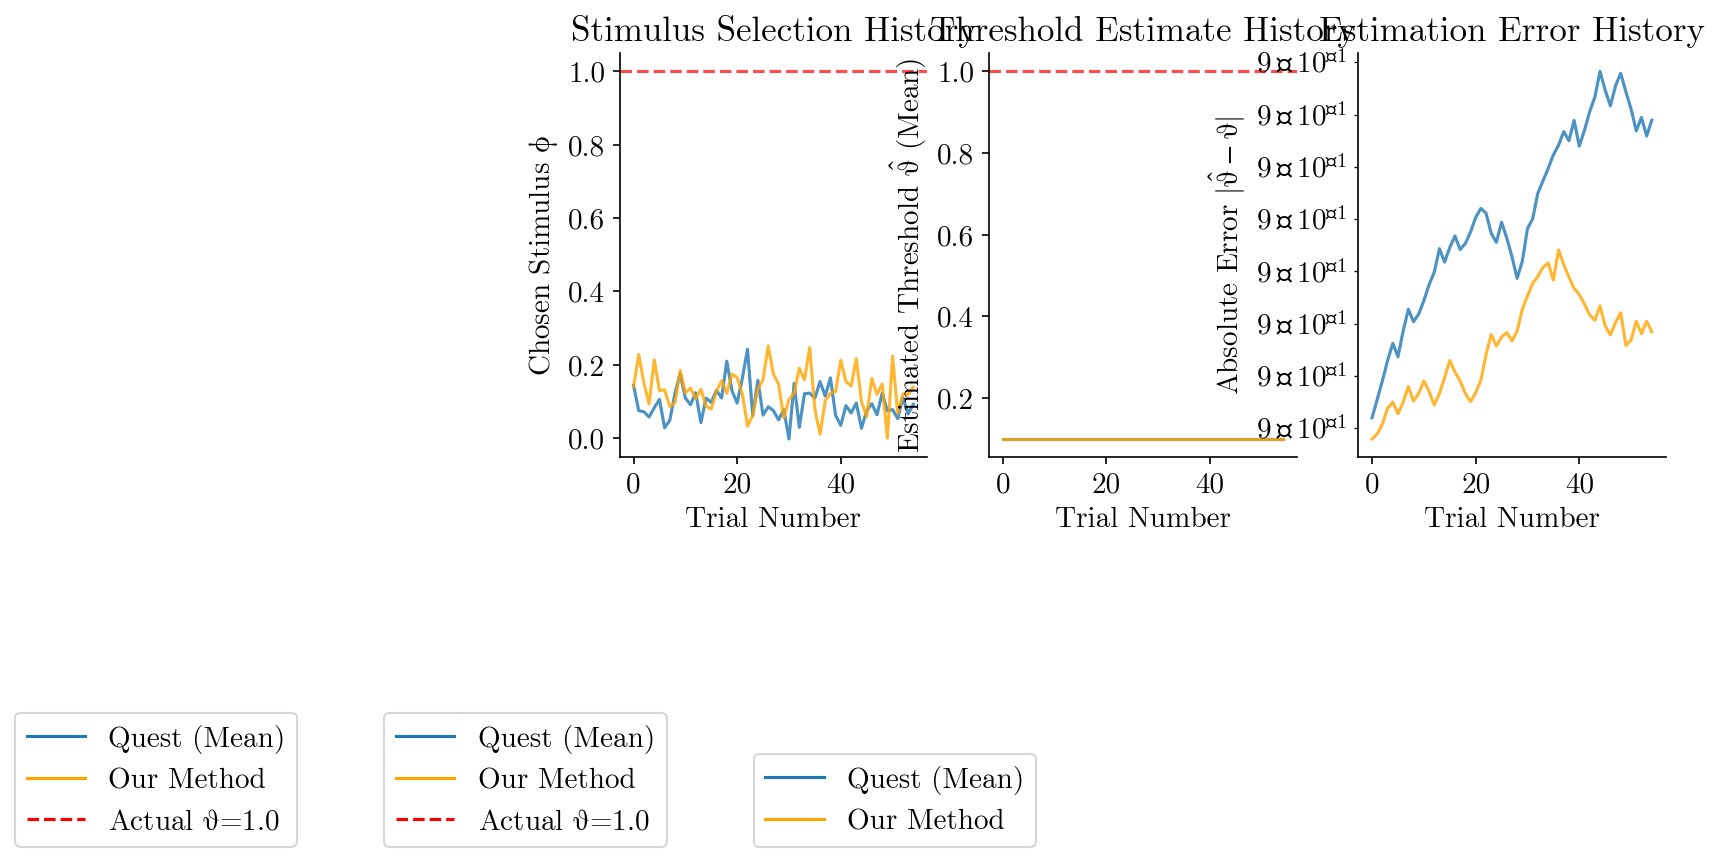


--- Running Scatter Plot Comparison ---


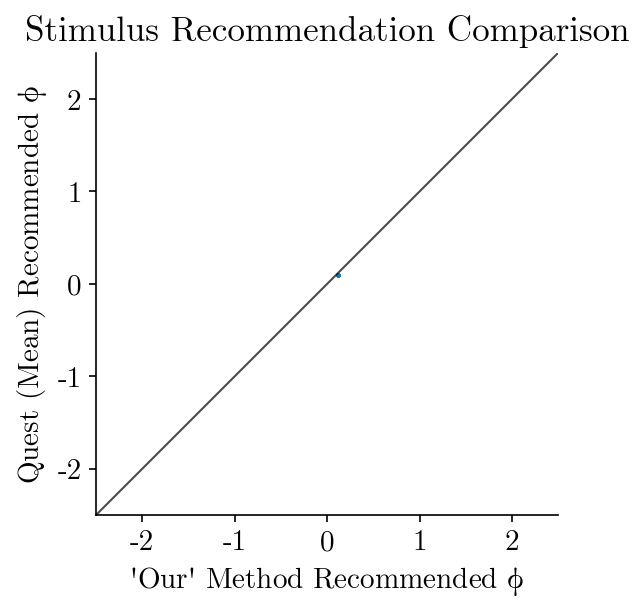

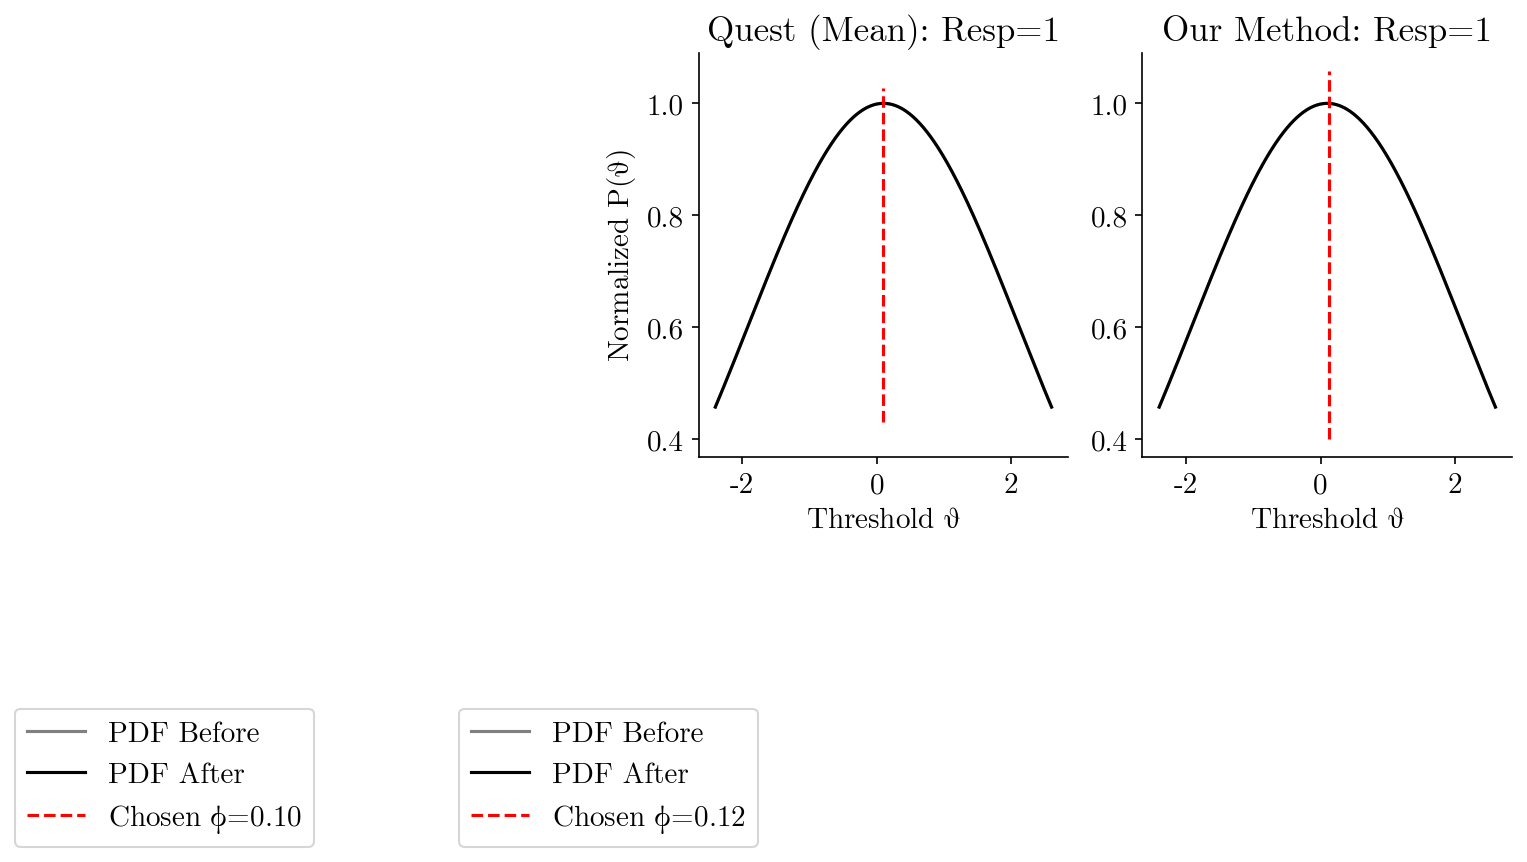

In [4]:
# --- Imports ---
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # Added for colormaps
from matplotlib.colors import ListedColormap, Normalize # Added for colorbar

# Assuming plot_ult.py contains initiate_plot, quickspine, quickleg
# If not, define dummy functions or remove calls
try:
    from plot_ult import *
except ImportError:
    print("Warning: plot_ult library not found. Plotting functions might fail or look basic.")
    # Define dummy functions if needed, e.g.:
    class DummyPlotContext:
        def __init__(self, *args, **kwargs): pass
        def __enter__(self): return plt.figure()
        def __exit__(self, *args): pass
        def add_subplot(self, *args, **kwargs): return plt.subplot(*args, **kwargs)
    initiate_plot = DummyPlotContext
    def quickspine(ax): ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
    def quickleg(ax, **kwargs): ax.legend(**kwargs)


# --- Utility Functions ---
def getinf(x):
    return np.nonzero(np.isinf(np.atleast_1d(x)))

def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

# --- QuestObject Class ( 그대로 유지 ) ---
# QuestObject class definition remains the same as in your original code
# ... (paste the full QuestObject class definition here) ...
class QuestObject():

    def __init__(self,tGuess,tGuessSd,pThreshold,beta,delta,gamma,grain=0.01,range=None):
        super(QuestObject, self).__init__()
        grain = float(grain) # make sure grain is a float
        if range is None:
            dim = 500
        else:
            if range <= 0:
                raise ValueError('argument "range" must be greater than zero.')
            dim=range/grain
            dim=2*math.ceil(dim/2.0) # round up to even integer
        self.updatePdf = True
        self.warnPdf = True
        self.normalizePdf = False
        self.tGuess = tGuess
        self.tGuessSd = tGuessSd
        self.pThreshold = pThreshold
        self.beta = beta
        self.delta = delta
        self.gamma = gamma
        self.grain = grain
        self.dim = dim
        self.recompute()

    def mean(self):
        """Mean of Quest posterior pdf."""
        denom = np.sum(self.pdf)
        if denom == 0: return self.tGuess # Avoid division by zero
        return self.tGuess + np.sum(self.pdf*self.x)/denom

    def mode(self):
        """Mode of Quest posterior pdf."""
        if not np.any(self.pdf): return self.tGuess # Handle empty pdf
        iMode = np.argmax(self.pdf) # Use argmax which is safer
        p=self.pdf[iMode]
        t=self.x[iMode]+self.tGuess
        return t

    def p(self,x):
        """probability of correct response at intensity x."""
        # Clip x to the range of x2 to avoid extrapolation errors
        x_clipped = np.clip(x, self.x2[0], self.x2[-1])
        return np.interp(x_clipped, self.x2, self.p2)

    def pdf_at(self,t):
        """The (unnormalized) probability density of candidate threshold 't'."""
        # Ensure index is within bounds
        i = int(round((t - self.tGuess) / self.grain)) + self.dim // 2 # Use // for integer division
        i = np.clip(i, 0, len(self.pdf) - 1)
        return self.pdf[i]


    def quantile(self,quantileOrder=None):
        """Get Quest recommendation for next trial level."""
        if quantileOrder is None:
            quantileOrder = self.quantileOrder
        
        p_sum = np.sum(self.pdf)
        if p_sum == 0:
             # Handle case where pdf is all zero, maybe return mean or mode?
             print("Warning: PDF sum is zero in quantile calculation. Returning mean.")
             return self.mean()

        p = np.cumsum(self.pdf)
        
        # Ensure p[-1] is not zero before dividing
        if p[-1] == 0:
            print("Warning: Cumulative PDF sum is zero. Returning mean.")
            return self.mean()

        # Find unique points in cumulative distribution
        unique_indices = np.unique(p, return_index=True)[1]
        unique_indices.sort() # Ensure indices are sorted

        if len(unique_indices) < 2:
            print("Warning: PDF has less than 2 unique cumulative points. Returning mode.")
            # If very few points, interpolation might fail or be meaningless
            return self.mode()

        # Use only unique points for interpolation
        p_unique = p[unique_indices]
        x_unique = self.x[unique_indices]

        # Interpolate; handle edge cases where quantileOrder might be 0 or 1 exactly
        target_val = quantileOrder * p_unique[-1]
        ires = np.interp(target_val, p_unique, x_unique)

        return self.tGuess + ires


    def sd(self):
        """Standard deviation of Quest posterior pdf."""
        p_sum = np.sum(self.pdf)
        if p_sum == 0: return np.inf # Or NaN, or raise error
        
        mean_x = np.sum(self.pdf * self.x) / p_sum
        mean_x2 = np.sum(self.pdf * self.x**2) / p_sum
        variance = mean_x2 - mean_x**2
        
        if variance < 0: # Handle potential floating point inaccuracies
            # print(f"Warning: Negative variance ({variance}) encountered in sd calculation. Setting SD to 0.")
            return 0.0
            
        return math.sqrt(variance)


    def simulate(self,tTest,tActual):
        """Simulate an observer with given Quest parameters."""
        # Calculate probability using the object's p method
        prob_correct = self.p(tTest - tActual)
        # Compare with random draw
        response = int(random.random() < prob_correct)
        return response

    def simulate_p(self,tTest,tActual):
        """Calculate probability of correct response for simulation."""
        # Use the object's p method directly
        return self.p(tTest - tActual)

    def recompute(self):
        """Recompute the psychometric function & pdf."""
        if not self.updatePdf:
            return
        if self.gamma > self.pThreshold:
            # warnings.warn( 'reducing gamma from %.2f to 0.5'%self.gamma)
            # print(f'Warning: reducing gamma from {self.gamma:.2f} to 0.5 to ensure threshold is reachable.')
            self.gamma = self.pThreshold # Reduce just enough, or to 0.5? Let's try just enough.
            if self.gamma > 0.5: self.gamma = 0.5 # Ensure it doesn't exceed 0.5


        # Use integer division for dim/2
        self.i = np.arange(-self.dim // 2, self.dim // 2 + 1)
        self.x = self.i * self.grain
        # Initialize PDF ensuring it's not zero if sd is very small/zero
        if self.tGuessSd <= 0:
             # Handle zero SD case: make a very narrow peak or uniform?
             # Let's make a peak at the center.
             self.pdf = np.zeros_like(self.x)
             mid_index = self.dim // 2
             self.pdf[mid_index] = 1.0
        else:
             self.pdf = np.exp(-0.5 * (self.x / self.tGuessSd)**2)

        pdf_sum = np.sum(self.pdf)
        if pdf_sum == 0: # Handle potential underflow if sd is huge
             self.pdf = np.ones_like(self.x) / len(self.x) # Uniform distribution
        else:
             self.pdf = self.pdf / pdf_sum

        # Calculate psychometric function points (x2, p2)
        i2 = np.arange(-self.dim, self.dim + 1)
        self.x2 = i2 * self.grain
        
        # Calculate base Weibull function part first
        weibull_part = 1 - (1 - self.gamma) * np.exp(-10**(self.beta * self.x2))
        # Apply delta scaling
        self.p2 = self.delta * self.gamma + (1 - self.delta) * weibull_part

        # Check if threshold is within the range of the calculated p2
        if self.p2[0] >= self.pThreshold or self.p2[-1] <= self.pThreshold:
             print(f"Warning: Psychometric function range [{self.p2[0]:.3f}, {self.p2[-1]:.3f}] might not contain pThreshold={self.pThreshold:.3f}. Adjusting range or parameters might be needed.")
             # Option: Clamp pThreshold if strictly necessary? Or just warn. Let's warn.
             # self.pThreshold = np.clip(self.pThreshold, self.p2[0] + 1e-6, self.p2[-1] - 1e-6)


        # Find threshold crossing using unique, monotonic points for stable interpolation
        valid_indices = np.where(np.diff(self.p2) > 1e-9)[0] # Indices where p2 is strictly increasing
        if len(valid_indices) < 1:
             print("Warning: Psychometric function p2 appears flat or non-monotonic. Cannot reliably find xThreshold.")
             self.xThreshold = 0 # Default or fallback value
        else:
              p2_mono = self.p2[valid_indices]
              x2_mono = self.x2[valid_indices]
              # Ensure pThreshold is within the monotonic range before interpolating
              interp_p_threshold = np.clip(self.pThreshold, p2_mono[0], p2_mono[-1])
              try:
                  self.xThreshold = np.interp(interp_p_threshold, p2_mono, x2_mono)
              except Exception as e:
                  print(f"Error during xThreshold interpolation: {e}. Setting xThreshold to 0.")
                  self.xThreshold = 0

        # Recalculate p2 centered around the estimated threshold
        weibull_part_shifted = 1 - (1 - self.gamma) * np.exp(-10**(self.beta * (self.x2 + self.xThreshold)))
        self.p2 = self.delta * self.gamma + (1 - self.delta) * weibull_part_shifted

        # Calculate success/failure probability arrays (s2)
        # Ensure p2 values are clipped between eps and 1-eps for numerical stability in s2
        eps = 1e-15
        p2_clipped = np.clip(self.p2, eps, 1.0 - eps)
        self.s2 = np.vstack(((1 - p2_clipped)[::-1], p2_clipped[::-1])) # failure, success rows

        # Initialize intensity and response history if not present
        if not hasattr(self,'intensity') or not hasattr(self,'response'):
            self.intensity = []
            self.response = []

        # Calculate optimal quantile order based on entropy (if needed, often using mean/mode is simpler)
        # Simplified placeholder for quantileOrder: often 0.5 (median) is used if entropy calc is complex/omitted
        # Or use the mean of the PDF as the target quantile
        self.quantileOrder = 0.5 # Default to median
        # If you want the entropy-based quantile:
        # eps = 1e-14
        # pL = self.p2[0]
        # pH = self.p2[-1]
        # # Calculate entropy difference, handle log(0) using eps
        # term1 = pH * np.log(pH + eps) if pH > -eps else 0
        # term2 = pL * np.log(pL + eps) if pL > -eps else 0
        # term3 = (1 - pH + eps) * np.log(1 - pH + eps)
        # term4 = (1 - pL + eps) * np.log(1 - pL + eps)
        # pE_numerator = term1 - term2 + term3 - term4
        # pE_denominator = pL - pH
        # if abs(pE_denominator) < eps: # Avoid division by zero if pL approx pH
        #      self.quantileOrder = 0.5 # Default if range is too narrow
        # else:
        #      # Calculate entropy term, handle potential exp overflow/underflow
        #      exp_arg = pE_numerator / pE_denominator
        #      # Clamp exp_arg to prevent overflow
        #      max_exp_arg = 700 # Approx limit for float64 exp
        #      exp_term = np.exp(np.clip(exp_arg, -max_exp_arg, max_exp_arg))
        #      pE = 1.0 / (1.0 + exp_term)
        #      # Calculate quantileOrder, ensure it's within [0, 1]
        #      if abs(pH - pL) < eps:
        #          self.quantileOrder = 0.5 # Default if range is tiny
        #      else:
        #          self.quantileOrder = (pE - pL) / (pH - pL)
        #      self.quantileOrder = np.clip(self.quantileOrder, 0.0, 1.0)


        # --- Recompute PDF based on history ---
        # Initialize with prior
        if self.tGuessSd <= 0:
             self.pdf = np.zeros_like(self.x)
             mid_index = self.dim // 2
             self.pdf[mid_index] = 1.0
        else:
             self.pdf = np.exp(-0.5 * (self.x / self.tGuessSd)**2)
        pdf_sum_initial = np.sum(self.pdf)
        if pdf_sum_initial == 0 :
             self.pdf = np.ones_like(self.x) / len(self.x)
        else:
             self.pdf = self.pdf / pdf_sum_initial
             
        # Apply updates from history
        for intensity, response in zip(self.intensity, self.response):
            if response not in [0, 1]: continue # Skip invalid responses

            # Calculate indices into s2 based on intensity relative to pdf center (tGuess)
            # inten = np.clip(intensity, -1e10, 1e10) # Ensure finite intensity
            relative_intensity = intensity - self.tGuess
            # Index calculation needs careful checking:
            # Base index in s2 corresponds to x2=0, which is index self.dim
            # An offset 'dx' in real units corresponds to dx/grain steps in index.
            # We want index for s2 corresponding to (theta - intensity)
            # which is equivalent to (self.x - relative_intensity)
            # Let target_x = self.x - relative_intensity
            # target_idx_in_x2 = target_x / self.grain + self.dim # Convert to index in x2 space
            
            # Let's rethink the index ii calculation from the original:
            # self.i ranges from -dim/2 to +dim/2
            # self.x = self.i * self.grain
            # target_x = inten - self.tGuess # Intensity relative to center of pdf
            # index_offset = round(target_x / self.grain)
            # s2 is indexed by (theta - intensity) / grain + dim
            # For a given pdf element at index j (corresponding to x[j] = self.i[j]*grain)
            # theta = x[j] + self.tGuess
            # We need s2 at index corresponding to (theta - inten)
            # theta - inten = x[j] + self.tGuess - inten = self.i[j]*grain - (inten - self.tGuess)
            #               = self.i[j]*grain - target_x
            # Index in s2 = (self.i[j]*grain - target_x) / self.grain + self.dim
            #             = self.i[j] - round(target_x / self.grain) + self.dim
            #             = self.i[j] - index_offset + self.dim

            # Since self.i[j] = j - self.dim/2
            # Index in s2 = j - self.dim/2 - index_offset + self.dim
            #             = j + self.dim/2 - index_offset

            # The original ii = len(self.pdf) + self.i - round((inten-self.tGuess)/self.grain) - 1 seems complex.
            # Let's recalculate indices directly for s2 lookup based on (theta-intensity).
            # For each potential theta in self.x + self.tGuess:
            thetas = self.x + self.tGuess
            delta_t = thetas - intensity
            
            # Convert delta_t to indices in self.x2 (which maps to self.s2)
            # Recall x2 = i2*grain where i2 ranges from -dim to dim.
            # Index in x2 = delta_t / self.grain
            # s2 index needs to be mapped from x2 index. s2 corresponds to x2[::-1].
            # Index in s2 is related to the index in the reversed x2.
            # Let idx_x2 = np.round(delta_t / self.grain).astype(int)
            # Need indices relative to the s2 array. s2 has length 2*dim + 1.
            # x2 has length 2*dim + 1, indices 0 to 2*dim.
            # x2 index = 0   corresponds to x2 = -dim*grain
            # x2 index = dim corresponds to x2 = 0
            # x2 index = 2*dim corresponds to x2 = +dim*grain
            
            # s2[response, k] corresponds to p(response | delta_t = x2_reversed[k])
            # x2_reversed = x2[::-1]. So x2_reversed[k] = x2[2*dim - k]
            # We need k such that x2[2*dim - k] = delta_t
            # (2*dim - k)*grain = delta_t
            # 2*dim - k = delta_t / grain
            # k = 2*dim - delta_t / grain
            
            s2_indices = 2 * self.dim - np.round(delta_t / self.grain)
            s2_indices = s2_indices.astype(int)

            # Clip indices to be valid for s2 (0 to 2*dim)
            s2_indices_clipped = np.clip(s2_indices, 0, 2 * self.dim)

            # Get the likelihood factor P(response | theta, intensity) for all thetas
            likelihood = self.s2[response, s2_indices_clipped]

            # Update pdf: pdf(theta) = pdf(theta) * P(response | theta, intensity)
            self.pdf = self.pdf * likelihood

            # Normalize periodically to prevent underflow/overflow
            if self.normalizePdf and (len(self.intensity) % 10 == 0): # Normalize more often?
                pdf_sum = np.sum(self.pdf)
                if pdf_sum > 1e-100: # Avoid normalizing if sum is effectively zero
                     self.pdf = self.pdf / pdf_sum
                else:
                     # Handle cases where pdf becomes all zero - reinitialize maybe?
                     # print("Warning: PDF sum zero during recompute history.")
                     # Reinitialize to uniform? Or keep as zero? Keeping zero for now.
                     self.pdf.fill(0)


        # Final normalization after applying all history
        pdf_sum_final = np.sum(self.pdf)
        if pdf_sum_final > 1e-100:
            self.pdf = self.pdf / pdf_sum_final
        else:
             # If pdf is zero after history, maybe the prior was bad or data inconsistent
             # print("Warning: Final PDF sum zero after recompute. Check parameters/history.")
             # Reinitialize to uniform as a fallback?
             self.pdf = np.ones_like(self.x) / len(self.x)
             
    def update(self,intensity,response):
        """Update Quest posterior pdf."""

        # Basic validation
        if response not in [0, 1]:
             print(f"Warning: Invalid response value {response} received. Trial skipped.")
             return # Skip update for invalid response

        # Store trial data FIRST
        self.intensity.append(intensity)
        self.response.append(response)

        if self.updatePdf:
            # Use the same logic as in recompute to get likelihoods
            thetas = self.x + self.tGuess
            delta_t = thetas - intensity
            s2_indices = 2 * self.dim - np.round(delta_t / self.grain)
            s2_indices = s2_indices.astype(int)
            
            # Check index bounds BEFORE clipping for warning
            min_idx, max_idx = np.min(s2_indices), np.max(s2_indices)
            if self.warnPdf and (min_idx < 0 or max_idx > 2 * self.dim):
                # Calculate the intensity range covered by s2
                # s2 covers delta_t from -dim*grain to +dim*grain
                # delta_t = theta - intensity => intensity = theta - delta_t
                # Max intensity corresponds to min delta_t => theta - (-dim*grain)
                # Min intensity corresponds to max delta_t => theta - (+dim*grain)
                # Since theta itself varies (self.x + self.tGuess), find overall range
                theta_min = self.x[0] + self.tGuess
                theta_max = self.x[-1] + self.tGuess
                inten_max_approx = theta_max + self.dim * self.grain
                inten_min_approx = theta_min - self.dim * self.grain
                # print(f"Warning: Intensity {intensity:.2f} may be outside the reliable range [{inten_min_approx:.2f}, {inten_max_approx:.2f}]. PDF update might be less accurate.")
                # self.warnPdf = False # Optional: Warn only once

            s2_indices_clipped = np.clip(s2_indices, 0, 2 * self.dim)
            likelihood = self.s2[response, s2_indices_clipped]

            self.pdf = self.pdf * likelihood

            if self.normalizePdf:
                pdf_sum = np.sum(self.pdf)
                if pdf_sum > 1e-100:
                     self.pdf = self.pdf / pdf_sum
                else:
                     # print("Warning: PDF sum zero during update.")
                     self.pdf.fill(0) # Or reinitialize?
        # No need to store history here, it's done at the start of the function

# --- Parameters ---
tActual = 1.5 # Ground truth threshold
tGuess = 0.1 # Initial guess (prior mean)
tGuessSd = 2.0 # Prior SD
pThreshold = 0.82 # Threshold definition (probability correct)
beta = 3.5 # Slope
delta = 0.01 # Lapse rate
gamma = 0.5 # Guess rate (chance level for 2AFC)
noise = 0.05 # Noise added to stimulus presentation (optional)

# --- Section 1: Original Quest Simulation & PDF Plotting (Modified) ---
trialsDesired = 20 # Let's do 20 trials for a clearer gradient
q_orig = QuestObject(tGuess, tGuessSd, pThreshold, beta, delta, gamma)
wrongRight = ('wrong', 'right')

# --- Plotting Setup for PDF Evolution ---
k_max = trialsDesired - 1
max_grey_level = 0.3 # Black to this grey level
# Create colormap for plotting PDF evolution
N_colors = 256
colors_subset = cm.gray(np.linspace(0, max_grey_level, N_colors))
pdf_cmap = ListedColormap(colors_subset)
pdf_norm = Normalize(vmin=0, vmax=k_max)

print("--- Running Original Quest Simulation (Modified PDF Plot) ---")
with initiate_plot(6, 4, 150) as fig_pdf_evo:
    ax_pdf_evo = fig_pdf_evo.add_subplot(111)

    for k in range(trialsDesired):
        # Get Quest recommendation (e.g., mean)
        tTest = q_orig.mean()
        # tTest = q_orig.quantile() # Alternative
        # tTest = q_orig.mode()    # Alternative

        # Simulate response
        response = q_orig.simulate(tTest, tActual)
        print(f'Trial {k+1:3d} at {tTest:6.2f} is {wrongRight[response]} (True Θ={tActual})')

        # Update Quest state
        q_orig.update(tTest, response)

        # --- Plot PDF with color gradient ---
        if k < 5 or (k + 1) % 5 == 0: # Plot first 5 and every 5th trial
            # pdf_sum = np.sum(q_orig.pdf) # Check sum before normalizing for plot
            # if pdf_sum > 1e-9:
            #     pdf_normalized_plot = q_orig.pdf / pdf_sum
            # else:
            #     pdf_normalized_plot = q_orig.pdf # Avoid division by zero

            # pdf_max = np.max(pdf_normalized_plot) # Use max of normalized PDF
            # if pdf_max > 1e-9:
            #      plot_data = pdf_normalized_plot / pdf_max
            # else:
            #      plot_data = pdf_normalized_plot # Avoid division by zero if max is zero
            pdf_to_plot = q_orig.pdf / np.max(q_orig.pdf) if np.max(q_orig.pdf) > 0 else q_orig.pdf


            plot_color = pdf_cmap(pdf_norm(k))
            ax_pdf_evo.plot(q_orig.tGuess + q_orig.x, pdf_to_plot,
                            color=plot_color, alpha=0.7) # Use tGuess offset for actual scale

    ax_pdf_evo.set_xlabel(r'Threshold $\theta$')
    ax_pdf_evo.set_ylabel(r'Normalized $P(\theta | \mathrm{data})$')
    ax_pdf_evo.set_title(f'Quest PDF Evolution (Trials 1-{trialsDesired})')
    quickspine(ax_pdf_evo)
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=pdf_cmap, norm=pdf_norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax_pdf_evo, label='Trial Number (k)')
    ax_pdf_evo.plot([tActual, tActual], ax_pdf_evo.get_ylim(), 'r--', alpha=0.6, label=f'Actual Θ ({tActual})')
    quickleg(ax_pdf_evo)

# --- Section 2: Other Plots and Analysis (Polished) ---

# Reinitialize Quest object for consistency in subsequent plots if needed
q = QuestObject(tGuess, tGuessSd, pThreshold, beta, delta, gamma)
# You might want to run a few updates here if the plots below assume some history
# Example: Run 5 trials
for _ in range(5):
     tTest = q.mean()
     response = q.simulate(tTest, tActual)
     q.update(tTest, response)


# --- Success/Failure Function Plot ---
with initiate_plot(4, 3, 150) as f_sf:
    ax_sf = f_sf.add_subplot(111)
    # Clip s2 values before log to avoid log(0)
    eps = 1e-15
    log_s2_0 = np.log(np.maximum(q.s2[0, :], eps))
    log_s2_1 = np.log(np.maximum(q.s2[1, :], eps))
    ax_sf.plot(q.x2, log_s2_0, label='log P(failure | Δt)') # s2[0] is 1-p2[::-1]
    ax_sf.plot(q.x2, log_s2_1, label='log P(success | Δt)') # s2[1] is p2[::-1]
    ax_sf.plot([0, 0], ax_sf.get_ylim(), '--', color='grey', alpha=0.7)
    ax_sf.set_xlim(-5, 5)
    ax_sf.set_xlabel(r'Intensity relative to threshold ($\phi - \theta$)')
    ax_sf.set_ylabel('Log Probability')
    ax_sf.set_title('Success/Failure Log Likelihood')
    quickspine(ax_sf)
    quickleg(ax_sf) # Legend might be crowded, consider position

# --- Psychometric Function Plot ---
with initiate_plot(4, 3, 150) as f_pf:
    ax_pf = f_pf.add_subplot(111)
    plot_intensities = q.tGuess + q.x # Plot vs absolute intensity
    probabilities = [q.simulate_p(xi, tActual) for xi in plot_intensities]
    ax_pf.plot(plot_intensities, probabilities, label=f'Psychometric Function (Actual $\\theta$={tActual})')
    ax_pf.plot([tActual, tActual], [-0.1, 1.1], '--', color='red', alpha=0.7, label=f'Actual $\\theta$')
    ax_pf.axhline(y=q.pThreshold, color='grey', linestyle=':', alpha=0.7, label=f'$pThreshold={q.pThreshold}$')
    ax_pf.set_xlabel(r'Stimulus Intensity ($\phi$)')
    ax_pf.set_ylabel('Probability Correct P($\checkmark$ | $\phi$)')
    ax_pf.set_ylim(-0.05, 1.05)
    ax_pf.set_title('Psychometric Function')
    quickspine(ax_pf)
    quickleg(ax_pf)


# --- Fisher Info / Convolution Calculation ('Our' Method Setup) ---
# Function to calculate Fisher Info kernel I0 (information vs delta_t)
def calculate_I0(q_obj):
    eps = 1e-9 # Avoid division by near zero
    # Use the internally calculated p2 and x2
    psy = q_obj.p2
    x = q_obj.x2
    # Calculate derivative using finite difference (gradient)
    dp_dx = np.gradient(psy, x, edge_order=2)
    # Fisher Information I0 = (dp/d(delta_t))^2 / (p*(1-p))
    # Ensure denominator is not zero
    denominator = psy * (1 - psy)
    I0 = dp_dx**2 / np.maximum(denominator, eps)
    # Return I0 and the corresponding x values (delta_t)
    # Often exclude edges where derivative/denominator is unstable
    return I0[1:-1], x[1:-1]

# Function to calculate expected info (convolution) for a given pdf
def calculate_expected_info(q_obj, I0, x_I0):
    priortheta_pdf = q_obj.pdf
    priortheta_x = q_obj.tGuess + q_obj.x # Absolute theta values for the PDF

    # We need to convolve prior P(theta) with I0(phi - theta)
    # This is equivalent to convolving P(theta) with I0(-delta_t) where delta_t = theta - phi
    # Let's flip I0: I0_flipped = I0[::-1] corresponding to x_I0_flipped = -x_I0[::-1]
    I0_flipped = I0[::-1]
    x_I0_flipped = -x_I0[::-1]

    # Interpolate I0_flipped onto the same grid spacing as the prior PDF for convolution
    # Need to handle the grid carefully. Assume q_obj.grain is the spacing.
    # Create a common high-resolution grid if necessary, or interpolate.

    # Simpler approach: For each potential phi, calculate the expected value directly
    # Expected Info(phi) = Sum[ P(theta) * I0(phi - theta) ] dtheta
    expected_info = []
    potential_phis = q_obj.tGuess + q_obj.x # Test phis on the same grid as theta posterior

    for phi in potential_phis:
        delta_t = phi - priortheta_x # phi - theta vector
        # Interpolate I0 values at these delta_t points
        interpolated_I0 = np.interp(delta_t, x_I0, I0, left=0, right=0) # Use original I0 and delta_t = phi - theta
        # Calculate expectation: sum over theta [ P(theta) * Interpolated_I0(phi-theta) ]
        info_for_phi = np.sum(priortheta_pdf * interpolated_I0) * q_obj.grain # Multiply by spacing if PDF is density
        expected_info.append(info_for_phi)

    return np.array(expected_info), potential_phis


# Calculate I0 kernel once
I0_kernel, x_I0_kernel = calculate_I0(q)

# Calculate expected info for the current state of q
conv, phis_for_conv = calculate_expected_info(q, I0_kernel, x_I0_kernel)
bestphi_our = phis_for_conv[np.argmax(conv)]

# --- Current Theta Estimation Plot ---
with initiate_plot(4, 3, 150) as f_theta:
    ax_theta = f_theta.add_subplot(111)
    current_mode = q.mode()
    pdf_to_plot = q.pdf / np.max(q.pdf) if np.max(q.pdf) > 0 else q.pdf
    ax_theta.plot(q.tGuess + q.x, pdf_to_plot, label='Current PDF')
    ax_theta.plot([current_mode, current_mode], [0, 1], '--', color='grey', label=f'Mode $\\theta$={current_mode:.2f}')
    ax_theta.plot([tActual, tActual], [0, 1], 'r--', alpha=0.6, label=f'Actual $\\theta$ ({tActual})')
    ax_theta.set_xlabel(r'Threshold $\theta$')
    ax_theta.set_ylabel(r'Normalized $P(\theta|\mathrm{data})$')
    ax_theta.set_title(f'Current Threshold Estimate (Mode={current_mode:.2f})')
    quickspine(ax_theta)
    quickleg(ax_theta)

# --- Best Phi Plot ('Our' Criterion) ---
with initiate_plot(4, 3, 150) as f_bestphi:
    ax_bestphi = f_bestphi.add_subplot(111)
    ax_bestphi.plot(phis_for_conv, conv, label='Expected Information')
    ax_bestphi.plot([bestphi_our, bestphi_our], [min(conv), max(conv)], '--', color='grey', label=f'Best $\\phi$={bestphi_our:.2f}')
    ax_bestphi.set_xlabel(r'Candidate Stimulus $\phi$')
    ax_bestphi.set_ylabel(r'Expected Information $I(\phi)$')
    ax_bestphi.set_title(f'Optimal Stimulus Selection (Our Method)')
    quickspine(ax_bestphi)
    quickleg(ax_bestphi)


# --- Section 3: Comparison Simulations ---
num_comparison_trials = 55
print(f"\n--- Running Comparison: Quest vs 'Our' ({num_comparison_trials} trials) ---")
tActual_comp = 1.0 # Use a different tActual for comparison simulation

q1 = QuestObject(tGuess, tGuessSd, pThreshold, beta, delta, gamma) # Quest (mean)
q2 = QuestObject(tGuess, tGuessSd, pThreshold, beta, delta, gamma) # Our method

phis1_hist = [] # History of phis chosen by Quest
phis2_hist = [] # History of phis chosen by 'Our' method
theta1_hist = [] # History of theta estimates (mean) for Quest
theta2_hist = [] # History of theta estimates (mean) for Our

# --- Setup figure for PDF evolution during comparison ---
k_max_comp = num_comparison_trials - 1
pdf_norm_comp = Normalize(vmin=0, vmax=k_max_comp)
with initiate_plot(7, 5, 150) as fig_comp_pdf_evo:
    ax_comp_pdf_evo = fig_comp_pdf_evo.add_subplot(111)
    ax_comp_pdf_evo.set_title(f"Quest PDF Evolution during Comparison (True Θ={tActual_comp})")
    ax_comp_pdf_evo.set_xlabel(r'Threshold $\theta$')
    ax_comp_pdf_evo.set_ylabel(r'Normalized $P(\theta | \mathrm{data})$')
    ax_comp_pdf_evo.plot([tActual_comp, tActual_comp], [0,1], 'r--', alpha=0.6, label=f'Actual Θ ({tActual_comp})')

    for i in range(num_comparison_trials):
        # --- q1 (Quest Mean) Update ---
        tTest1 = q1.mean()
        tTest1 = tTest1 + (np.random.normal() * noise) # Add noise
        response1 = q1.simulate(tTest1, tActual_comp)
        q1.update(tTest1, response1)
        phis1_hist.append(tTest1)
        theta1_hist.append(q1.mean())

        # --- q2 ('Our' Method) Update ---
        # Recalculate expected info for q2's current state
        conv2, phis_for_conv2 = calculate_expected_info(q2, I0_kernel, x_I0_kernel)
        if len(conv2) > 0 and np.any(conv2): # Ensure conv2 is not empty or all zero
             tTest2 = phis_for_conv2[np.argmax(conv2)]
        else:
             tTest2 = q2.mean() # Fallback to mean if info calculation fails
             print(f"Warning: 'Our' method failed at trial {i+1}, using mean.")

        tTest2 = tTest2 + (np.random.normal() * noise) # Add noise
        response2 = q2.simulate(tTest2, tActual_comp)
        q2.update(tTest2, response2)
        phis2_hist.append(tTest2)
        theta2_hist.append(q2.mean())

        # --- Plot q1 PDF evolution ---
        # Plot only some trials for clarity
        if i < 5 or (i + 1) % 5 == 0:
            pdf_to_plot = q1.pdf / np.max(q1.pdf) if np.max(q1.pdf) > 0 else q1.pdf
            plot_color = pdf_cmap(pdf_norm_comp(i)) # Use the same black-to-grey map
            ax_comp_pdf_evo.plot(q1.tGuess + q1.x, pdf_to_plot, color=plot_color, alpha=0.7)

    # Add colorbar to the comparison PDF plot
    sm_comp = plt.cm.ScalarMappable(cmap=pdf_cmap, norm=pdf_norm_comp)
    sm_comp.set_array([])
    cbar_comp = plt.colorbar(sm_comp, ax=ax_comp_pdf_evo, label='Trial Number (i)')
    quickspine(ax_comp_pdf_evo)
    # Final legend might be too crowded, maybe omit or place carefully
    # quickleg(ax_comp_pdf_evo)


# --- Plot Comparison Results ---
with initiate_plot(9, 3.5, 150) as f_conv:
    # Plot chosen Phi values over trials
    ax1 = f_conv.add_subplot(131)
    ax1.plot(range(num_comparison_trials), phis1_hist, label='Quest (Mean)', alpha=0.8)
    ax1.plot(range(num_comparison_trials), phis2_hist, label='Our Method', alpha=0.8, color='orange')
    ax1.axhline(tActual_comp, color='red', linestyle='--', label=f'Actual $\\theta$={tActual_comp:.1f}', alpha=0.7)
    ax1.set_xlabel('Trial Number')
    ax1.set_ylabel(r'Chosen Stimulus $\phi$')
    ax1.set_title('Stimulus Selection History')
    quickspine(ax1)
    quickleg(ax1)

    # Plot Theta estimates over trials
    ax2 = f_conv.add_subplot(132, sharex=ax1)
    ax2.plot(range(num_comparison_trials), theta1_hist, label='Quest (Mean)', alpha=0.8)
    ax2.plot(range(num_comparison_trials), theta2_hist, label='Our Method', alpha=0.8, color='orange')
    ax2.axhline(tActual_comp, color='red', linestyle='--', label=f'Actual $\\theta$={tActual_comp:.1f}', alpha=0.7)
    ax2.set_xlabel('Trial Number')
    ax2.set_ylabel(r'Estimated Threshold $\hat{\theta}$ (Mean)')
    ax2.set_title('Threshold Estimate History')
    quickspine(ax2)
    quickleg(ax2)

    # Plot absolute error in Theta estimate
    ax3 = f_conv.add_subplot(133, sharex=ax1)
    error1 = np.abs(np.array(theta1_hist) - tActual_comp)
    error2 = np.abs(np.array(theta2_hist) - tActual_comp)
    ax3.plot(range(num_comparison_trials), error1, label='Quest (Mean)', alpha=0.8)
    ax3.plot(range(num_comparison_trials), error2, label='Our Method', alpha=0.8, color='orange')
    ax3.set_xlabel('Trial Number')
    ax3.set_ylabel(r'Absolute Error $|\hat{\theta} - \theta|$')
    ax3.set_title('Estimation Error History')
    ax3.set_yscale('log') # Log scale often useful for errors
    quickspine(ax3)
    quickleg(ax3)
    plt.tight_layout()


# --- Scatter Plot Comparison (using simulated history) ---
# This section compared phis chosen by different methods given *identical* histories.
# We need to regenerate this data carefully if desired.
# The original code iterated through tActual values, but updated only q1,
# then compared q1.mean() to the 'our' best phi based on q1's state.
print("\n--- Running Scatter Plot Comparison ---")
phis1_scatter = []
phis2_scatter = []
num_scatter_tasks = 50
num_trials_per_task = 10 # Fewer trials per task for scatter

for task_idx in range(num_scatter_tasks):
    # Vary tActual slightly for each task
    tActual_scatter = np.random.uniform(-1.5, 1.5)
    q_scatter = QuestObject(tGuess, tGuessSd, pThreshold, beta, delta, gamma) # Reset for each task

    for trial_idx in range(num_trials_per_task):
        # Quest selection (mean)
        tTest_q = q_scatter.mean()
        phis1_scatter.append(tTest_q)

        # 'Our' selection based on current q_scatter state
        conv_scatter, phis_for_conv_scatter = calculate_expected_info(q_scatter, I0_kernel, x_I0_kernel)
        if len(conv_scatter) > 0 and np.any(conv_scatter):
            tTest_our = phis_for_conv_scatter[np.argmax(conv_scatter)]
        else:
            tTest_our = tTest_q # Fallback
        phis2_scatter.append(tTest_our)

        # Simulate trial using Quest selection (or 'our' selection?)
        # Original used Quest's selection + noise to update state
        tTest_sim = tTest_q + (np.random.normal() * noise)
        response_sim = q_scatter.simulate(tTest_sim, tActual_scatter)
        q_scatter.update(tTest_sim, response_sim)

# Plot the scatter comparison
with initiate_plot(4, 4, 150) as f_scatter:
    ax_scatter = f_scatter.add_subplot(111)
    ax_scatter.scatter(phis2_scatter, phis1_scatter, s=1, alpha=0.3)
    ax_scatter.set_xlabel(r"'Our' Method Recommended $\phi$")
    ax_scatter.set_ylabel(r"Quest (Mean) Recommended $\phi$")
    ax_scatter.set_title(r"Stimulus Recommendation Comparison")
    # Add identity line
    lims = [min(ax_scatter.get_xlim()[0], ax_scatter.get_ylim()[0], -2.5),
            max(ax_scatter.get_xlim()[1], ax_scatter.get_ylim()[1], 2.5)]
    ax_scatter.plot(lims, lims, 'k-', alpha=0.7, lw=1)
    ax_scatter.set_xlim(lims)
    ax_scatter.set_ylim(lims)
    ax_scatter.set_aspect('equal', adjustable='box')
    quickspine(ax_scatter)


# --- Final Single Trial Comparison Plot (Example) ---
# Reset objects
q1_final = QuestObject(tGuess, tGuessSd, pThreshold, beta, delta, gamma)
q2_final = QuestObject(tGuess, tGuessSd, pThreshold, beta, delta, gamma)
# Give them some identical history (e.g., 5 trials)
tActual_final = 0.5
for _ in range(5):
    # Use Quest mean for simulation consistency
    tTest_shared = q1_final.mean() + (np.random.normal() * noise)
    response_shared = q1_final.simulate(tTest_shared, tActual_final)
    q1_final.update(tTest_shared, response_shared)
    q2_final.update(tTest_shared, response_shared) # Update both with same trial

with initiate_plot(7, 3.5, 150) as f_final_comp:
    ax1_fc = f_final_comp.add_subplot(1, 2, 1)
    ax2_fc = f_final_comp.add_subplot(1, 2, 2, sharey=ax1_fc)

    # Plot state before this step's choice
    pdf1_before = q1_final.pdf / np.max(q1_final.pdf) if np.max(q1_final.pdf) > 0 else q1_final.pdf
    pdf2_before = q2_final.pdf / np.max(q2_final.pdf) if np.max(q2_final.pdf) > 0 else q2_final.pdf
    ax1_fc.plot(q1_final.tGuess + q1_final.x, pdf1_before, color='grey', alpha=0.6, label='PDF Before')
    ax2_fc.plot(q2_final.tGuess + q2_final.x, pdf2_before, color='grey', alpha=0.6, label='PDF Before')


    # --- Quest (Mean) Selection and Update ---
    tTest_f1 = q1_final.mean()
    response_f1 = q1_final.simulate(tTest_f1 + (np.random.normal() * noise), tActual_final) # Simulate with noise maybe?
    q1_final.update(tTest_f1 + (np.random.normal() * noise), response_f1) # Update with noise? Or without? Let's update without noise for clarity
    # q1_final.update(tTest_f1, response_f1) # Update with chosen value

    pdf1_after = q1_final.pdf / np.max(q1_final.pdf) if np.max(q1_final.pdf) > 0 else q1_final.pdf
    ax1_fc.plot(q1_final.tGuess + q1_final.x, pdf1_after, color='k', alpha=1, label='PDF After')
    ax1_fc.plot([tTest_f1, tTest_f1], ax1_fc.get_ylim(), color='red', linestyle='--', label=f'Chosen $\\phi$={tTest_f1:.2f}')
    ax1_fc.set_title(f'Quest (Mean): Resp={response_f1}')
    ax1_fc.set_xlabel(r'Threshold $\theta$')
    ax1_fc.set_ylabel(r'Normalized $P(\theta)$')
    quickspine(ax1_fc)
    quickleg(ax1_fc)

    # --- 'Our' Method Selection and Update ---
    conv_f2, phis_for_conv_f2 = calculate_expected_info(q2_final, I0_kernel, x_I0_kernel)
    if len(conv_f2) > 0 and np.any(conv_f2):
         tTest_f2 = phis_for_conv_f2[np.argmax(conv_f2)]
    else:
         tTest_f2 = q2_final.mean() # Fallback

    response_f2 = q2_final.simulate(tTest_f2 + (np.random.normal() * noise), tActual_final)
    q2_final.update(tTest_f2 + (np.random.normal() * noise), response_f2)
    # q2_final.update(tTest_f2, response_f2) # Update with chosen value

    pdf2_after = q2_final.pdf / np.max(q2_final.pdf) if np.max(q2_final.pdf) > 0 else q2_final.pdf
    ax2_fc.plot(q2_final.tGuess + q2_final.x, pdf2_after, color='k', alpha=1, label='PDF After')
    ax2_fc.plot([tTest_f2, tTest_f2], ax2_fc.get_ylim(), color='red', linestyle='--', label=f'Chosen $\\phi$={tTest_f2:.2f}')
    ax2_fc.set_title(f'Our Method: Resp={response_f2}')
    ax2_fc.set_xlabel(r'Threshold $\theta$')
    # ax2_fc.set_ylabel(r'Normalized $P(\theta)$') # Shared Y
    quickspine(ax2_fc)
    quickleg(ax2_fc)

    plt.tight_layout()

# --- Remove Debugging Plots ---
# plt.plot(p*(1-p)) # Removed
# plt.plot(q.x,[abs(0.75-q.simulate_p(0,theta))*priorp for priorp,theta in zip(q.pdf/sum(q.pdf),q.x)]) # Removed

# --- Show all generated figures ---
plt.show()